Loaded df with shape: (2151, 36)
Fitting original logistic propensity models...
Experiment 1 (ditf) done
Experiment 2 (diti) done
Experiment 3 (ditf interactions) done
Experiment 4 (diti interactions) done

Running DML cross-fit (RF) for ditf...
DML (ditf) ATE (crossfit RF): 2.8803878554237636 SE: 25.295015976214785
DML (ditf) ATE (no-crossfit RF): 23.068246821818125 SE: 8.162376266812169

Running DML cross-fit (RF) for diti...
DML (diti) ATE (crossfit RF): -3.7961911042900605 SE: 18.520602293067572
DML (diti) ATE (no-crossfit RF): -5.355916406465837 SE: 7.6314287802612535

Running matching for each PS variant and plotting distributions...

Experiment: ditf | PS: ps_ditf_1
ATT (Effect on yield) using ps_ditf_1: -2.7476552014319395


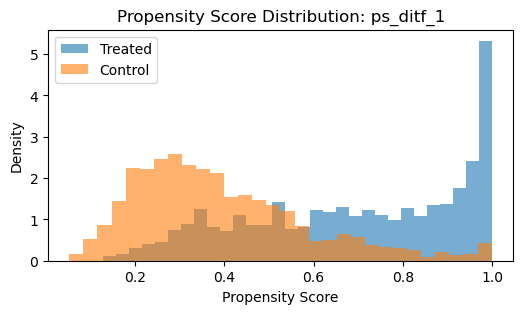


Experiment: ditf | PS: ps_ditf_scaled_1
ATT (Effect on yield) using ps_ditf_scaled_1: -14.198438845722876


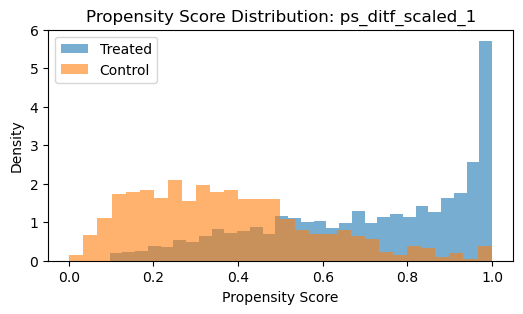


Experiment: diti | PS: ps_diti_2
ATT (Effect on yield) using ps_diti_2: -84.34095159598763


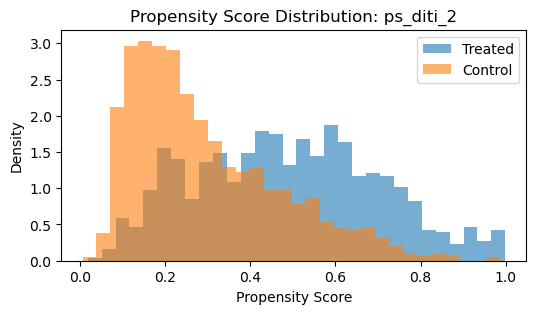


Experiment: diti | PS: ps_diti_scaled_2
ATT (Effect on yield) using ps_diti_scaled_2: -15.336081072992215


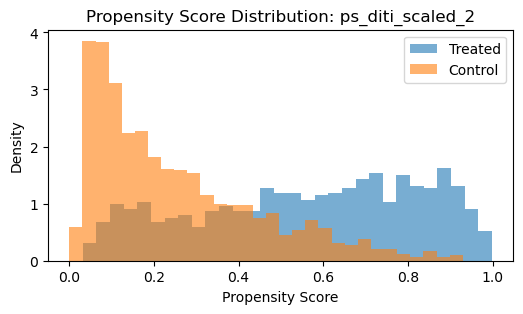


Experiment: ditf | PS: ps_ditf_int_3
ATT (Effect on yield) using ps_ditf_int_3: -6.40402041721029


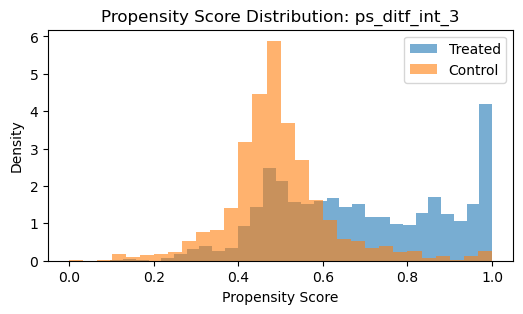


Experiment: ditf | PS: ps_ditf_int_scaled_3
ATT (Effect on yield) using ps_ditf_int_scaled_3: -74.01122979454647


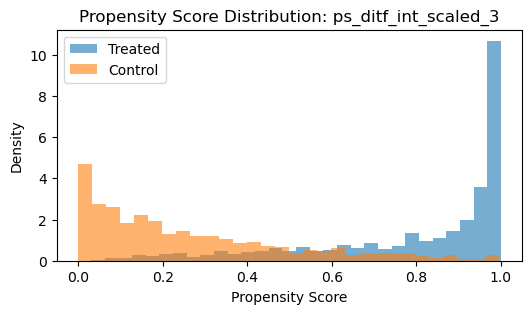


Experiment: diti | PS: ps_diti_int_4
ATT (Effect on yield) using ps_diti_int_4: -21.25356923864814


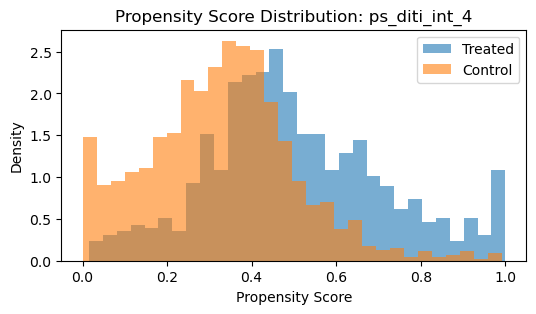


Experiment: diti | PS: ps_diti_int_scaled_4
ATT (Effect on yield) using ps_diti_int_scaled_4: -157.9032688481467


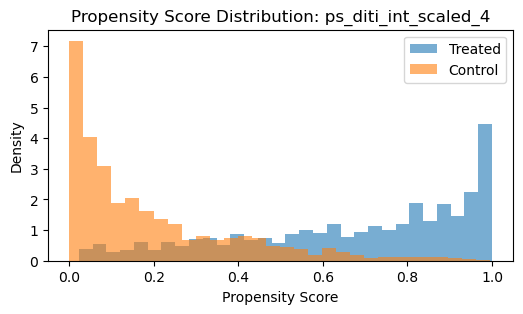


Experiment: ditf | PS: ps_ditf_dml_rf_cross
ATT (Effect on yield) using ps_ditf_dml_rf_cross: -187.73249820999752


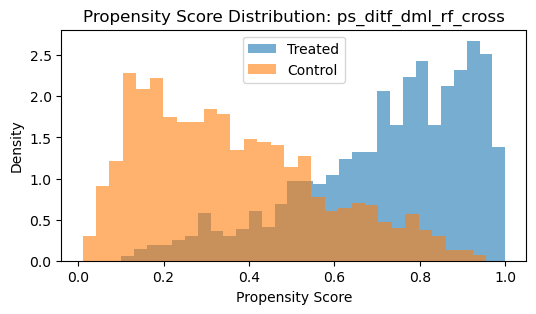


Experiment: ditf | PS: ps_ditf_dml_rf_nocross
ATT (Effect on yield) using ps_ditf_dml_rf_nocross: 200.40498495417717


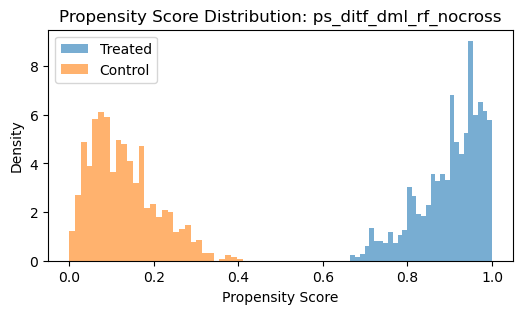


Experiment: diti | PS: ps_diti_dml_rf_cross
ATT (Effect on yield) using ps_diti_dml_rf_cross: -33.36566669113785


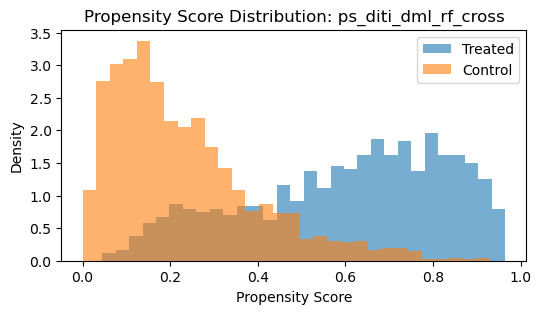


Experiment: diti | PS: ps_diti_dml_rf_nocross
ATT (Effect on yield) using ps_diti_dml_rf_nocross: 304.7374119150395


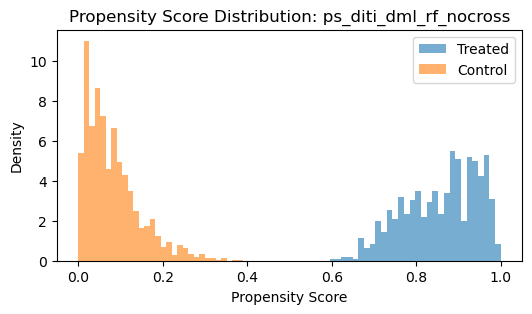



==== SUMMARY OF ALL ATT EFFECTS (Yield) ====

ps_ditf_1                            ATT(yield) = -2.7476552014319395
ps_ditf_scaled_1                     ATT(yield) = -14.198438845722876
ps_diti_2                            ATT(yield) = -84.34095159598763
ps_diti_scaled_2                     ATT(yield) = -15.336081072992215
ps_ditf_int_3                        ATT(yield) = -6.40402041721029
ps_ditf_int_scaled_3                 ATT(yield) = -74.01122979454647
ps_diti_int_4                        ATT(yield) = -21.25356923864814
ps_diti_int_scaled_4                 ATT(yield) = -157.9032688481467
ps_ditf_dml_rf_cross                 ATT(yield) = -187.73249820999752
ps_ditf_dml_rf_nocross               ATT(yield) = 200.40498495417717
ps_diti_dml_rf_cross                 ATT(yield) = -33.36566669113785
ps_diti_dml_rf_nocross               ATT(yield) = 304.7374119150395


========= SMD DIAGNOSTICS (BEFORE vs AFTER MATCHING) =========


------ ps_ditf_1 (ditf) ------

Top 5 WORST BEFORE MATC

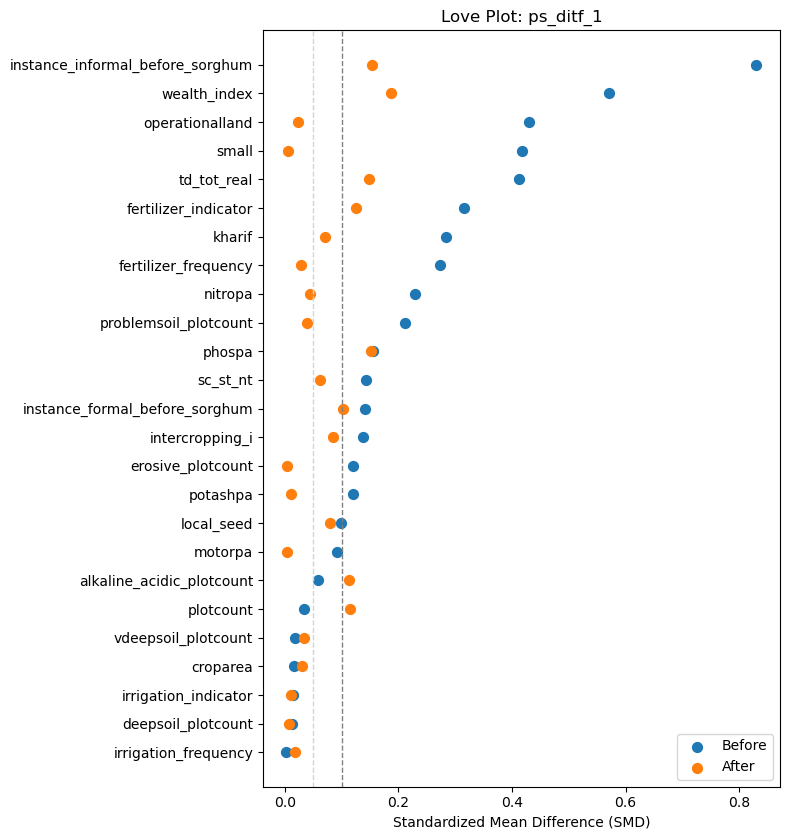

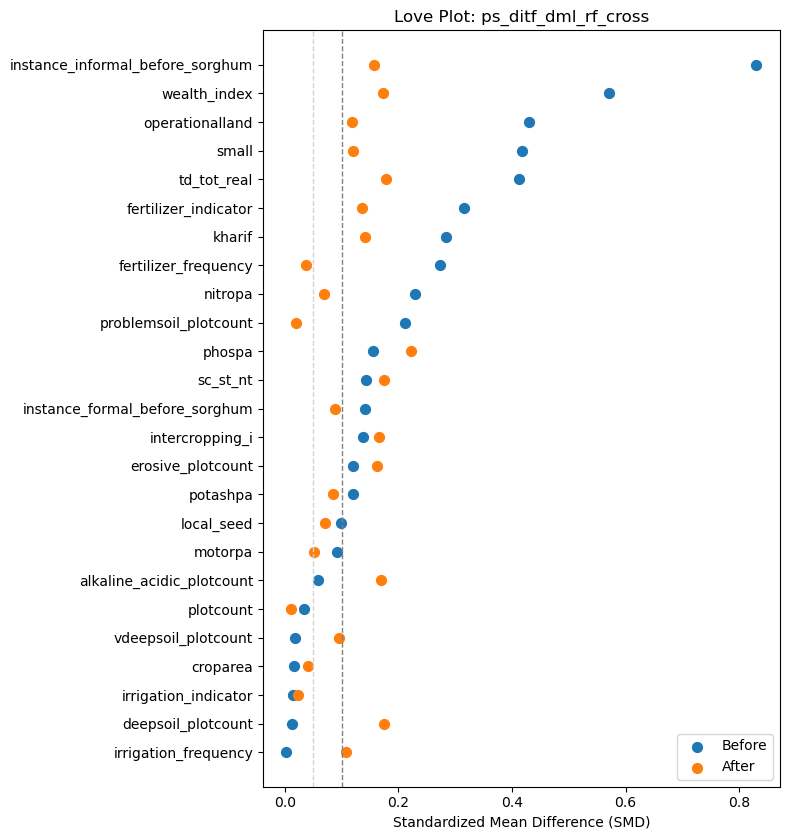

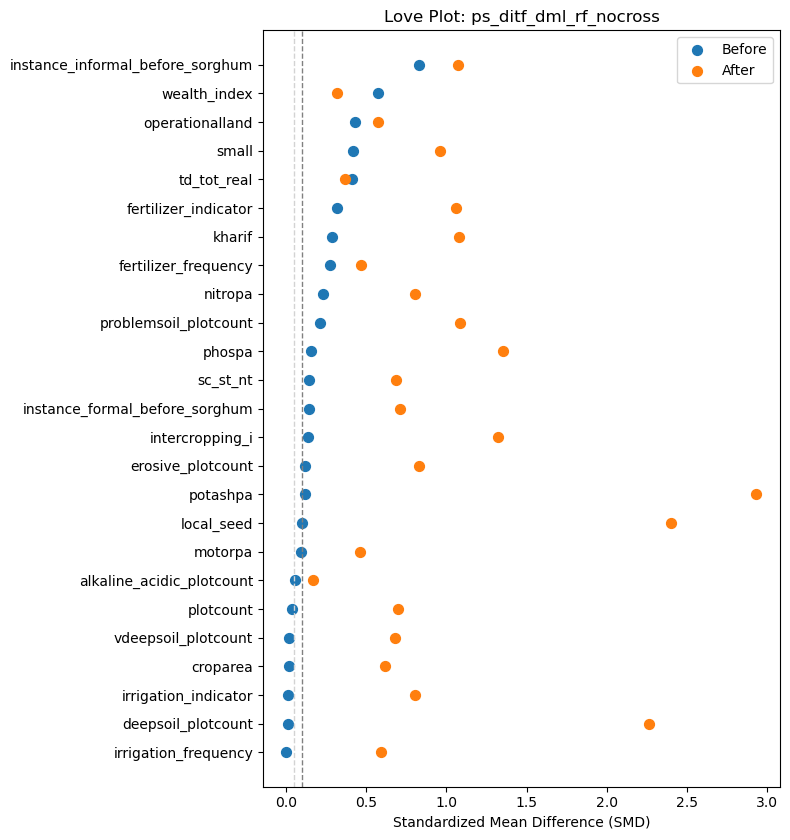

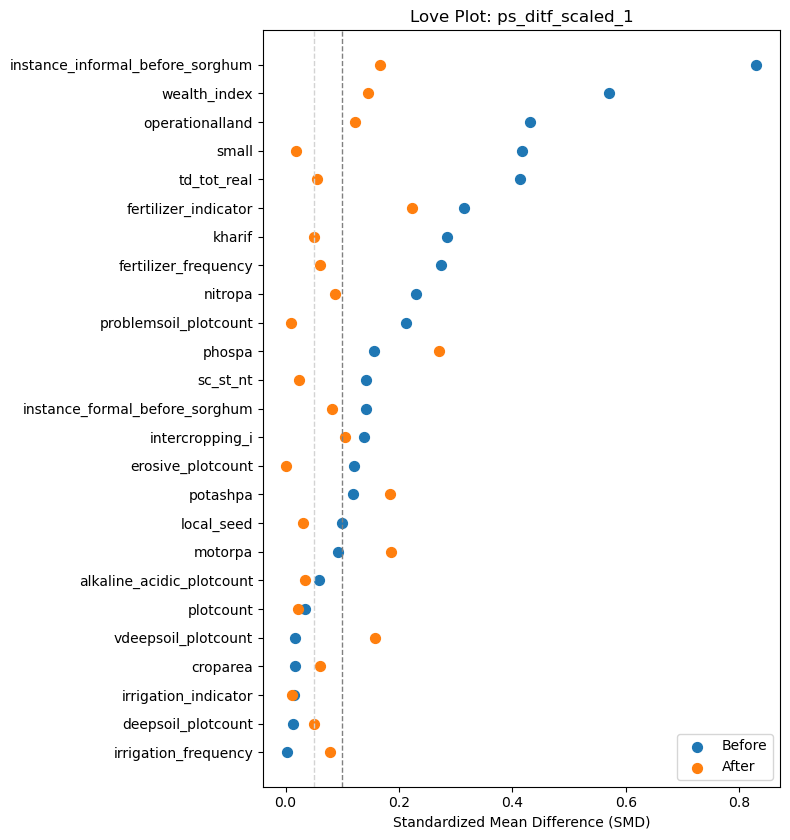



==== DML SUMMARY ====
ditf_DML_RF_cross               ATE = 2.880388   SE = 25.295016
ditf_DML_RF_nocross             ATE = 23.068247   SE = 8.162376
diti_DML_RF_cross               ATE = -3.796191   SE = 18.520602
diti_DML_RF_nocross             ATE = -5.355916   SE = 7.631429

Dataframe with PS columns saved to: v4_with_ps.csv


In [15]:
# === FULL END-TO-END PIPELINE: LOAD -> PS (LOGIT & DML) -> MATCHING -> SMDs -> PLOTS ===

# 0) Imports
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

# -------------------------
# 1) Load data
# -------------------------
CSV_PATH = "v4.csv"   # <-- change path if necessary
df = pd.read_csv(CSV_PATH)
print("Loaded df with shape:", df.shape)

# -------------------------
# 2) Baseline variable lists + helper functions (exact as your baseline)
# -------------------------
treat = "ditf"
treat2 = "diti"
temp_fix_ef = "year"

cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()

    # add pairwise interactions
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)

    # categorical dummies
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

    # year FE
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)

    # numeric conversion
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")

    return X

# -------------------------
# 3) Original logistic propensity fitting (keeps names from your baseline)
# -------------------------
def fit_pscore(df, treat_col, include_interaction=False, scaled=False):
    y = df[treat_col].astype(int)
    X = prepare_X(df, include_interaction)

    if scaled:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # add intercept column for sklearn logistic (not strictly necessary)
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X, y)
    ps = lr.predict_proba(X)[:, 1]
    return lr, ps

# Compute original logistic PS columns (mirrors your earlier runs)
print("Fitting original logistic propensity models...")
model1_orig, ps1_orig = fit_pscore(df, treat, include_interaction=False, scaled=False)
model1_scaled, ps1_scaled = fit_pscore(df, treat, include_interaction=False, scaled=True)
df["ps_ditf_1"] = ps1_orig
df["ps_ditf_scaled_1"] = ps1_scaled
print("Experiment 1 (ditf) done")

model2_orig, ps2_orig = fit_pscore(df, treat2, include_interaction=False, scaled=False)
model2_scaled, ps2_scaled = fit_pscore(df, treat2, include_interaction=False, scaled=True)
df["ps_diti_2"] = ps2_orig
df["ps_diti_scaled_2"] = ps2_scaled
print("Experiment 2 (diti) done")

model3_orig, ps3_orig = fit_pscore(df, treat, include_interaction=True, scaled=False)
model3_scaled, ps3_scaled = fit_pscore(df, treat, include_interaction=True, scaled=True)
df["ps_ditf_int_3"] = ps3_orig
df["ps_ditf_int_scaled_3"] = ps3_scaled
print("Experiment 3 (ditf interactions) done")

model4_orig, ps4_orig = fit_pscore(df, treat2, include_interaction=True, scaled=False)
model4_scaled, ps4_scaled = fit_pscore(df, treat2, include_interaction=True, scaled=True)
df["ps_diti_int_4"] = ps4_orig
df["ps_diti_int_scaled_4"] = ps4_scaled
print("Experiment 4 (diti interactions) done")

# -------------------------
# 4) DML: cross-fitting implementation for ATE (out-of-fold p, m0, m1)
# -------------------------
def dml_ate_crossfit(
    df,
    treat_col,
    outcome_col="yield",
    X_cols=None,
    n_splits=5,
    prop_model=None,
    m_model_treated=None,
    m_model_control=None,
    random_state=42,
):
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    # default learners
    if prop_model is None:
        prop_model = RandomForestClassifier(n_estimators=200, random_state=random_state)
    if m_model_treated is None:
        m_model_treated = RandomForestRegressor(n_estimators=200, random_state=random_state)
    if m_model_control is None:
        m_model_control = RandomForestRegressor(n_estimators=200, random_state=random_state)

    n = df.shape[0]
    p_oof = np.zeros(n)
    m0_oof = np.zeros(n)
    m1_oof = np.zeros(n)

    X_full = df[X_cols].copy()
    # scale numeric features for ML
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    X_use = pd.DataFrame(X_scaled, columns=X_cols, index=df.index)

    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(X_use):
        X_tr = X_use.iloc[train_idx]
        X_te = X_use.iloc[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # propensity
        prop_model.fit(X_tr, t_tr)
        p_hat = prop_model.predict_proba(X_te)[:, 1]
        p_oof[test_idx] = p_hat

        # outcome models: fit on treated/control in train
        treat_mask = (t_tr == 1)
        ctrl_mask = (t_tr == 0)
        # handle small-sample corner cases:
        if np.sum(treat_mask) < 5 or np.sum(ctrl_mask) < 5:
            # fallback: single regressor with T as feature
            alt = RandomForestRegressor(n_estimators=100, random_state=random_state)
            X_tr_alt = X_tr.copy()
            X_tr_alt['T_flag'] = t_tr
            alt.fit(X_tr_alt, y_tr)
            X_te_alt1 = X_te.copy(); X_te_alt1['T_flag'] = 1
            X_te_alt0 = X_te.copy(); X_te_alt0['T_flag'] = 0
            m1_oof[test_idx] = alt.predict(X_te_alt1)
            m0_oof[test_idx] = alt.predict(X_te_alt0)
        else:
            m_model_treated.fit(X_tr.loc[treat_mask], y_tr[treat_mask])
            m_model_control.fit(X_tr.loc[ctrl_mask], y_tr[ctrl_mask])
            m1_oof[test_idx] = m_model_treated.predict(X_te)
            m0_oof[test_idx] = m_model_control.predict(X_te)

    # clip p
    eps = 1e-6
    p_oof = np.clip(p_oof, eps, 1 - eps)

    # influence function for ATE
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_oof, "m0_oof": m0_oof, "m1_oof": m1_oof}

# No-crossfit (train on all, evaluate on all) baseline
def dml_ate_no_crossfit(df, treat_col, outcome_col="yield", X_cols=None, random_state=42):
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    X_full = df[X_cols].copy()
    scaler = StandardScaler()
    X_use = pd.DataFrame(scaler.fit_transform(X_full), columns=X_cols, index=df.index)

    prop = RandomForestClassifier(n_estimators=200, random_state=random_state)
    m_t = RandomForestRegressor(n_estimators=200, random_state=random_state)
    m_c = RandomForestRegressor(n_estimators=200, random_state=random_state)

    t = df[treat_col].astype(int).values
    y = df[outcome_col].values

    prop.fit(X_use, t)
    p_hat = prop.predict_proba(X_use)[:, 1]
    p_hat = np.clip(p_hat, 1e-6, 1 - 1e-6)

    # fit outcome models on treated/control
    if np.sum(t == 1) < 5 or np.sum(t == 0) < 5:
        # fallback combined
        alt = RandomForestRegressor(n_estimators=100, random_state=random_state)
        X_withT = X_use.copy(); X_withT['T_flag'] = t
        alt.fit(X_withT, y)
        X1 = X_use.copy(); X1['T_flag'] = 1
        X0 = X_use.copy(); X0['T_flag'] = 0
        m1_hat = alt.predict(X1)
        m0_hat = alt.predict(X0)
    else:
        m_t.fit(X_use.loc[df[treat_col] == 1], df.loc[df[treat_col] == 1, outcome_col])
        m_c.fit(X_use.loc[df[treat_col] == 0], df.loc[df[treat_col] == 0, outcome_col])
        m1_hat = m_t.predict(X_use)
        m0_hat = m_c.predict(X_use)

    psi = (m1_hat - m0_hat) + (t * (y - m1_hat) / p_hat) - ((1 - t) * (y - m0_hat) / (1 - p_hat))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))
    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_hat, "m0_oof": m0_hat, "m1_oof": m1_hat}

# -------------------------
# 5) Run DML experiments for both treatments and save PS columns
# -------------------------
print("\nRunning DML cross-fit (RF) for ditf...")
# build X_cols identical to prepare_X(include_interaction=False)
X_all = prepare_X(df, include_interaction=False)
X_cols = X_all.columns.tolist()
# Attach X_all columns to df temporarily (used by some matchers later)
for c in X_cols:
    df[c] = X_all[c]

# DML crossfit (RF baseline)
res_ditf_rf = dml_ate_crossfit(df, treat_col="ditf", outcome_col="yield", X_cols=X_cols, n_splits=5)
df["ps_ditf_dml_rf_cross"] = res_ditf_rf["p_oof"]
df["m0_ditf_dml_rf_cross"] = res_ditf_rf["m0_oof"]
df["m1_ditf_dml_rf_cross"] = res_ditf_rf["m1_oof"]

# DML no-crossfit
res_ditf_rf_nocf = dml_ate_no_crossfit(df, treat_col="ditf", outcome_col="yield", X_cols=X_cols)
df["ps_ditf_dml_rf_nocross"] = res_ditf_rf_nocf["p_oof"]

print("DML (ditf) ATE (crossfit RF):", res_ditf_rf["ATE"], "SE:", res_ditf_rf["ATE_se"])
print("DML (ditf) ATE (no-crossfit RF):", res_ditf_rf_nocf["ATE"], "SE:", res_ditf_rf_nocf["ATE_se"])

print("\nRunning DML cross-fit (RF) for diti...")
res_diti_rf = dml_ate_crossfit(df, treat_col="diti", outcome_col="yield", X_cols=X_cols, n_splits=5)
df["ps_diti_dml_rf_cross"] = res_diti_rf["p_oof"]
df["m0_diti_dml_rf_cross"] = res_diti_rf["m0_oof"]
df["m1_diti_dml_rf_cross"] = res_diti_rf["m1_oof"]

res_diti_rf_nocf = dml_ate_no_crossfit(df, treat_col="diti", outcome_col="yield", X_cols=X_cols)
df["ps_diti_dml_rf_nocross"] = res_diti_rf_nocf["p_oof"]

print("DML (diti) ATE (crossfit RF):", res_diti_rf["ATE"], "SE:", res_diti_rf["ATE_se"])
print("DML (diti) ATE (no-crossfit RF):", res_diti_rf_nocf["ATE"], "SE:", res_diti_rf_nocf["ATE_se"])

# -------------------------
# 6) Matching and ATT estimation (Nearest neighbor by PS)
# -------------------------
def nearest_neighbor_att(df, treat_col, ps_col, outcome="yield"):
    df2 = df[[treat_col, ps_col, outcome]].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1]
    control = df2[df2[treat_col] == 0]

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(control[[ps_col]])
    distances, indices = nbrs.kneighbors(treated[[ps_col]])

    matched_control = control.iloc[indices.flatten()].copy()
    # ATT: mean(Y_treated) - mean(Y_matched_control)
    att = treated[outcome].values.mean() - matched_control[outcome].values.mean()
    # return treated full and matched_control full passed via indices for SMD checks
    treated_full = df.loc[treated.index]
    control_full = df.loc[matched_control.index]
    return att, treated_full, control_full

# ---- LIST OF TREATMENT + PS COLUMN MAPPINGS (mirrors your earlier experiments + DML)
experiments = [
    ("ditf", "ps_ditf_1"),
    ("ditf", "ps_ditf_scaled_1"),
    ("diti", "ps_diti_2"),
    ("diti", "ps_diti_scaled_2"),
    ("ditf", "ps_ditf_int_3"),
    ("ditf", "ps_ditf_int_scaled_3"),
    ("diti", "ps_diti_int_4"),
    ("diti", "ps_diti_int_scaled_4"),
    ("ditf", "ps_ditf_dml_rf_cross"),
    ("ditf", "ps_ditf_dml_rf_nocross"),
    ("diti", "ps_diti_dml_rf_cross"),
    ("diti", "ps_diti_dml_rf_nocross"),
]

results = []
print("\nRunning matching for each PS variant and plotting distributions...")
for treat_col, ps_col in experiments:
    if ps_col not in df.columns:
        print(f"Warning: {ps_col} not found in df columns; skipping.")
        results.append((ps_col, np.nan))
        continue

    print("\n==============================")
    print(f"Experiment: {treat_col} | PS: {ps_col}")
    print("==============================")

    att, treated, control = nearest_neighbor_att(df, treat_col, ps_col, outcome="yield")
    results.append((ps_col, att))
    print(f"ATT (Effect on yield) using {ps_col}: {att}")

    # PS distribution plot (treated vs control)
    plt.figure(figsize=(6,3))
    plt.hist(df.loc[df[treat_col]==1, ps_col].dropna(), bins=30, alpha=0.6, density=True, label="Treated")
    plt.hist(df.loc[df[treat_col]==0, ps_col].dropna(), bins=30, alpha=0.6, density=True, label="Control")
    plt.title(f"Propensity Score Distribution: {ps_col}")
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Summary table of ATT
print("\n\n==== SUMMARY OF ALL ATT EFFECTS (Yield) ====\n")
for ps_col, att in results:
    print(f"{ps_col:<35}  ATT(yield) = {att}")

# -------------------------
# 7) SMD computation functions (before & after matching) and diagnostics
# -------------------------
def compute_smd(treated, control, col):
    """Compute standardized mean difference for ONE variable (absolute value)."""
    mean_t = treated[col].mean()
    mean_c = control[col].mean()

    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0:
        return 0.0
    return abs(mean_t - mean_c) / pooled_sd

def smd_before_matching(df, treat_col, covariates):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd_dict = {}
    for col in covariates:
        if col in df.columns:
            smd_dict[col] = compute_smd(treated, control, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])

def smd_after_matching(treated_matched, control_matched, covariates):
    smd_dict = {}
    for col in covariates:
        if col in treated_matched.columns and col in control_matched.columns:
            smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])

# Run SMD diagnostics for each experiment
print("\n\n========= SMD DIAGNOSTICS (BEFORE vs AFTER MATCHING) =========\n")
smd_results = {}
for treat_col, ps_col in experiments:
    if ps_col not in df.columns:
        continue
    print(f"\n------ {ps_col} ({treat_col}) ------")
    smd_b = smd_before_matching(df, treat_col, other_cols)
    att, treated_m, control_m = nearest_neighbor_att(df, treat_col, ps_col, outcome="yield")
    if treated_m is None or control_m is None:
        print("No matched sets found; skipping SMD after matching.")
        continue
    smd_a = smd_after_matching(treated_m, control_m, other_cols)
    smd_results[ps_col] = (smd_b, smd_a)

    print("\nTop 5 WORST BEFORE MATCHING:")
    print(smd_b.sort_values("SMD_before", ascending=False).head())

    print("\nTop 5 WORST AFTER MATCHING:")
    print(smd_a.sort_values("SMD_after", ascending=False).head())

# -------------------------
# 8) Love plot function + generate for key PS columns (keeps plots readable)
# -------------------------
def love_plot(smd_before_df, smd_after_df, title, max_vars=40):
    df_plot = smd_before_df.join(smd_after_df, how='inner')
    df_plot = df_plot.dropna()
    df_plot = df_plot.sort_values("SMD_before", ascending=True)
    # limit variables for readability
    if df_plot.shape[0] > max_vars:
        df_plot = df_plot.tail(max_vars)

    plt.figure(figsize=(8, len(df_plot) * 0.22 + 3))
    y_pos = range(len(df_plot))

    plt.scatter(df_plot["SMD_before"], y_pos, label="Before", s=50)
    plt.scatter(df_plot["SMD_after"], y_pos, label="After", s=50)

    plt.axvline(0.1, color="gray", linestyle="--", linewidth=1)
    plt.axvline(0.05, color="lightgray", linestyle="--", linewidth=1)

    plt.yticks(y_pos, df_plot.index)
    plt.xlabel("Standardized Mean Difference (SMD)")
    plt.title(f"Love Plot: {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nGenerating Love Plots for selected PS models...\n")
# choose a subset to plot (not all at once)
to_plot = ["ps_ditf_1", "ps_ditf_dml_rf_cross", "ps_ditf_dml_rf_nocross", "ps_ditf_scaled_1"]
for ps_col in to_plot:
    if ps_col in smd_results:
        smd_b, smd_a = smd_results[ps_col]
        love_plot(smd_b, smd_a, title=ps_col)
    else:
        print(f"Skipping love plot for {ps_col} (SMD results not available).")

# -------------------------
# 9) Final summary outputs saved to df and printed
# -------------------------
# Save DML ATEs to a summary
summary = []
summary.append(("ditf_DML_RF_cross", res_ditf_rf["ATE"], res_ditf_rf["ATE_se"]))
summary.append(("ditf_DML_RF_nocross", res_ditf_rf_nocf["ATE"], res_ditf_rf_nocf["ATE_se"]))
summary.append(("diti_DML_RF_cross", res_diti_rf["ATE"], res_diti_rf["ATE_se"]))
summary.append(("diti_DML_RF_nocross", res_diti_rf_nocf["ATE"], res_diti_rf_nocf["ATE_se"]))

print("\n\n==== DML SUMMARY ====")
for name, ate, se in summary:
    print(f"{name:<30}  ATE = {ate:.6f}   SE = {se:.6f}")

# Optionally write df with PS columns to disk
OUT_PATH = "v4_with_ps.csv"
df.to_csv(OUT_PATH, index=False)
print(f"\nDataframe with PS columns saved to: {OUT_PATH}")


In [16]:
# ---------- SMD SUMMARY TABLE (run this after your pipeline) ----------
import pandas as pd
import numpy as np

# list of PS columns you ran (same as the experiments list in your pipeline)
ps_columns = [
    "ps_ditf_1", "ps_ditf_scaled_1", "ps_diti_2", "ps_diti_scaled_2",
    "ps_ditf_int_3", "ps_ditf_int_scaled_3", "ps_diti_int_4", "ps_diti_int_scaled_4",
    "ps_ditf_dml_rf_cross", "ps_ditf_dml_rf_nocross", "ps_diti_dml_rf_cross", "ps_diti_dml_rf_nocross"
]

# helper functions (same as before but safe)
def compute_smd_single(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0 or np.isnan(pooled_sd):
        return np.nan
    return abs(mean_t - mean_c) / pooled_sd

def smd_before_matching_df(df, treat_col, covars):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd = {}
    for c in covars:
        if c in df.columns:
            smd[c] = compute_smd_single(treated, control, c)
        else:
            smd[c] = np.nan
    return pd.Series(smd)

def smd_after_matching_df(treated_matched, control_matched, covars):
    # treated_matched and control_matched should be DataFrames of matched sets with same covariate columns
    smd = {}
    for c in covars:
        if c in treated_matched.columns and c in control_matched.columns:
            smd[c] = compute_smd_single(treated_matched, control_matched, c)
        else:
            smd[c] = np.nan
    return pd.Series(smd)

# iterate and build summary
rows = []
for ps in ps_columns:
    if ps not in df.columns:
        print(f"Skipping {ps}: not present in df")
        continue

    # BEFORE matching SMDs (full sample)
    s_before = smd_before_matching_df(df, "ditf" if "ditf" in ps else "diti", other_cols)
    mean_before = s_before.dropna().mean()

    # perform NN matching like your function to get treated_matched and matched_control
    from sklearn.neighbors import NearestNeighbors

    treat_col = "ditf" if "ditf" in ps else "diti"
    df2 = df[[treat_col, ps] + other_cols + ["yield"]].dropna().copy()
    df2 = df2.sort_values(ps)

    treated = df2[df2[treat_col] == 1]
    control = df2[df2[treat_col] == 0]

    if len(treated) == 0 or len(control) == 0:
        print(f"No treated or control for {ps}; skipping after-matching stats.")
        rows.append({
            "ps_col": ps,
            "mean_smd_before": mean_before,
            "mean_smd_after": np.nan,
            "count_smd_gt_0.1_after": np.nan,
            "count_smd_gt_0.2_after": np.nan,
            "count_smd_gt_0.5_after": np.nan,
            "top5_before": ", ".join([f"{idx}:{val:.3f}" for idx, val in s_before.dropna().sort_values(ascending=False).head(5).items()]),
            "top5_after": ""
        })
        continue

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(control[[ps]])
    distances, indices = nbrs.kneighbors(treated[[ps]])
    matched_control = control.iloc[indices.flatten()].copy()

    # Align back to original df to preserve full covariates (if you attached full X to df earlier)
    treated_full = df.loc[treated.index]
    control_full = df.loc[matched_control.index]

    s_after = smd_after_matching_df(treated_full, control_full, other_cols)
    mean_after = s_after.dropna().mean()

    count_gt_0_1 = (s_after.dropna() > 0.1).sum()
    count_gt_0_2 = (s_after.dropna() > 0.2).sum()
    count_gt_0_5 = (s_after.dropna() > 0.5).sum()

    top5_before = ", ".join([f"{idx}:{val:.3f}" for idx, val in s_before.dropna().sort_values(ascending=False).head(5).items()])
    top5_after = ", ".join([f"{idx}:{val:.3f}" for idx, val in s_after.dropna().sort_values(ascending=False).head(5).items()])

    rows.append({
        "ps_col": ps,
        "mean_smd_before": mean_before,
        "mean_smd_after": mean_after,
        "count_smd_gt_0.1_after": int(count_gt_0_1),
        "count_smd_gt_0.2_after": int(count_gt_0_2),
        "count_smd_gt_0.5_after": int(count_gt_0_5),
        "top5_before": top5_before,
        "top5_after": top5_after
    })

smd_summary = pd.DataFrame(rows)
smd_summary = smd_summary.set_index("ps_col")
# nicer column order
smd_summary = smd_summary[[
    "mean_smd_before", "mean_smd_after",
    "count_smd_gt_0.1_after", "count_smd_gt_0.2_after", "count_smd_gt_0.5_after",
    "top5_before", "top5_after"
]]

# print nicely
pd.set_option('display.max_colwidth', 200)
print("\nSMD Summary table (first rows):")
print(smd_summary)

# save to CSV
smd_summary.to_csv("smd_summary.csv")
print("\nSaved SMD summary to smd_summary.csv")



SMD Summary table (first rows):
                        mean_smd_before  mean_smd_after  \
ps_col                                                    
ps_ditf_1                      0.205837        0.066254   
ps_ditf_scaled_1               0.205837        0.089347   
ps_diti_2                      0.168371        0.066436   
ps_diti_scaled_2               0.168371        0.055297   
ps_ditf_int_3                  0.205837        0.058390   
ps_ditf_int_scaled_3           0.205837        0.178555   
ps_diti_int_4                  0.168371        0.073235   
ps_diti_int_scaled_4           0.168371        0.135764   
ps_ditf_dml_rf_cross           0.205837        0.111914   
ps_ditf_dml_rf_nocross         0.205837        0.972639   
ps_diti_dml_rf_cross           0.168371        0.095280   
ps_diti_dml_rf_nocross         0.168371        0.775742   

                        count_smd_gt_0.1_after  count_smd_gt_0.2_after  \
ps_col                                                            

In [17]:
# ===========================
#  SUMMARY TABLE (LIKE SCREENSHOT)
# ===========================

import pandas as pd

def classify_model(max_smd):
    """Assign verdict category based on thresholds."""
    if max_smd <= 0.15:
        return "Best"
    elif max_smd <= 0.20:
        return "Good"
    elif max_smd <= 0.25:
        return "Acceptable"
    elif max_smd <= 0.30:
        return "Weak"
    elif max_smd <= 0.35:
        return "Poor"
    else:
        return "Worst"

summary_rows = []

for ps_col, (smd_before, smd_after) in smd_results.items():
    smd_after_series = smd_after["SMD_after"].dropna()
    max_smd_after = smd_after_series.max()

    # Extract Treatment (ditf or diti)
    treatment = "ditf" if "ditf" in ps_col else "diti"

    # Identify interaction
    interaction = "Yes" if "int" in ps_col else "No"

    # Identify scaling (scaled or not)
    scaled = "Yes" if "scaled" in ps_col else "No"

    verdict = classify_model(max_smd_after)

    summary_rows.append({
        "PS Model": ps_col,
        "Treatment": treatment,
        "Interaction": interaction,
        "Scaled": scaled,
        "Max SMD_after": round(max_smd_after, 3),
        "Verdict": verdict
    })


summary_table = pd.DataFrame(summary_rows)
summary_table = summary_table.sort_values("Max SMD_after")

print("\n===== FINAL SUMMARY TABLE =====\n")
print(summary_table)

# Save to CSV for your report
summary_table.to_csv("ps_model_smd_summary_table.csv", index=False)
print("\nSaved as: ps_model_smd_summary_table.csv")



===== FINAL SUMMARY TABLE =====

                  PS Model Treatment Interaction Scaled  Max SMD_after  \
2                ps_diti_2      diti          No     No          0.179   
4            ps_ditf_int_3      ditf         Yes     No          0.179   
0                ps_ditf_1      ditf          No     No          0.187   
6            ps_diti_int_4      diti         Yes     No          0.207   
8     ps_ditf_dml_rf_cross      ditf          No     No          0.222   
10    ps_diti_dml_rf_cross      diti          No     No          0.244   
7     ps_diti_int_scaled_4      diti         Yes    Yes          0.268   
1         ps_ditf_scaled_1      ditf          No    Yes          0.270   
3         ps_diti_scaled_2      diti          No    Yes          0.281   
5     ps_ditf_int_scaled_3      ditf         Yes    Yes          0.372   
11  ps_diti_dml_rf_nocross      diti          No     No          2.508   
9   ps_ditf_dml_rf_nocross      ditf          No     No          2.932   

   

## Final

Loaded df with shape: (2151, 36)
Fitting original logistic propensity models...
Experiment 1 (ditf) done
Experiment 2 (diti) done
Experiment 3 (ditf interactions) done
Experiment 4 (diti interactions) done

Running DML cross-fit (RF) for ditf...
DML (ditf) ATE (crossfit RF): 2.8803878554237636 SE: 25.295015976214785
DML (ditf) ATE (no-crossfit RF): 23.068246821818125 SE: 8.162376266812169

Running DML cross-fit (RF) for diti...
DML (diti) ATE (crossfit RF): -3.7961911042900605 SE: 18.520602293067572
DML (diti) ATE (no-crossfit RF): -5.355916406465837 SE: 7.6314287802612535

Running caliper matching for each PS variant and plotting distributions...

Experiment: ditf | PS: ps_ditf_1
ATT (Effect on yield) using ps_ditf_1 (caliper=0.05): 2.769979977562002


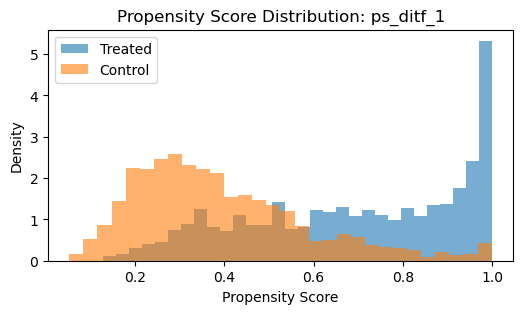


Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                                SMD_after
deepsoil_plotcount               0.059473
problemsoil_plotcount            0.059064
fertilizer_indicator             0.054771
local_seed                       0.054107
instance_formal_before_sorghum   0.053773

Experiment: ditf | PS: ps_ditf_scaled_1
ATT (Effect on yield) using ps_ditf_scaled_1 (caliper=0.05): 26.9154415814603


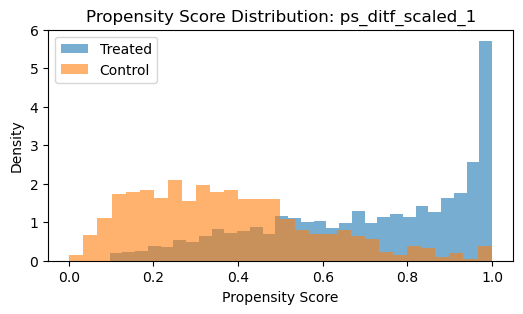


Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                                  SMD_after
operationalland                    0.085003
instance_informal_before_sorghum   0.073243
plotcount                          0.068439
croparea                           0.054796
small                              0.053492

Experiment: diti | PS: ps_diti_2
ATT (Effect on yield) using ps_diti_2 (caliper=0.05): -55.70016612297252


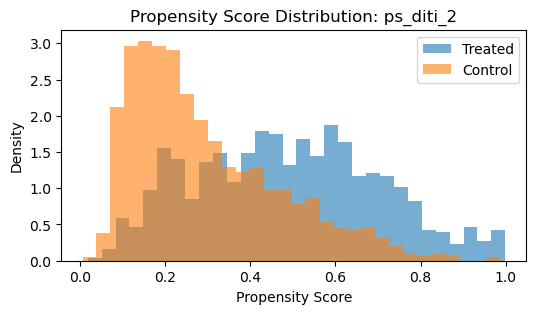


Top 5 WORST BEFORE MATCHING:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766

Top 5 WORST AFTER MATCHING:
                           SMD_after
alkaline_acidic_plotcount   0.081794
operationalland             0.060772
motorpa                     0.057035
sc_st_nt                    0.053685
plotcount                   0.051835

Experiment: diti | PS: ps_diti_scaled_2
ATT (Effect on yield) using ps_diti_scaled_2 (caliper=0.05): -7.799336116180143


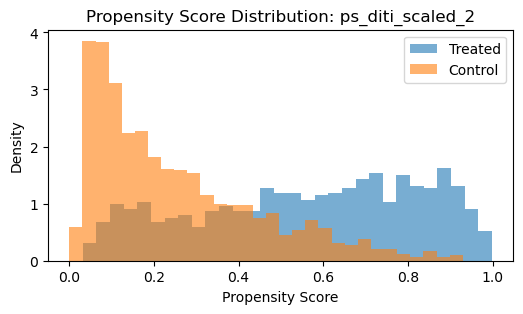


Top 5 WORST BEFORE MATCHING:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766

Top 5 WORST AFTER MATCHING:
                                SMD_after
nitropa                          0.061159
fertilizer_indicator             0.060181
potashpa                         0.057320
instance_formal_before_sorghum   0.038581
plotcount                        0.035584

Experiment: ditf | PS: ps_ditf_int_3
ATT (Effect on yield) using ps_ditf_int_3 (caliper=0.05): 79.19406795752678


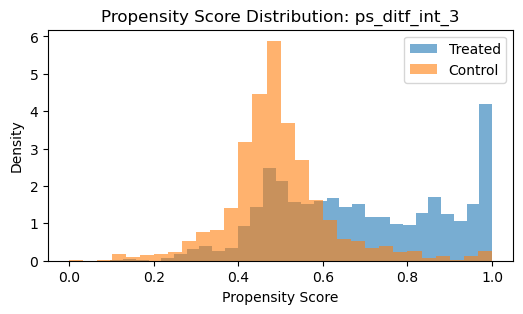


Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                                  SMD_after
operationalland                    0.194229
croparea                           0.181104
kharif                             0.155923
fertilizer_indicator               0.151806
instance_informal_before_sorghum   0.141755

Experiment: ditf | PS: ps_ditf_int_scaled_3
ATT (Effect on yield) using ps_ditf_int_scaled_3 (caliper=0.05): -21.192587867425914


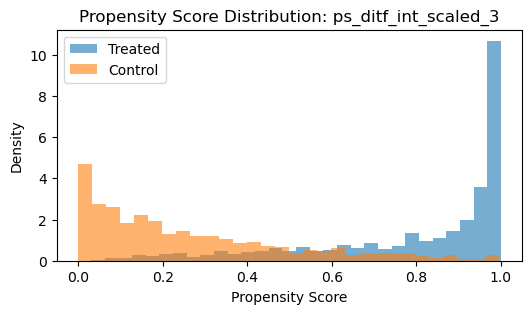


Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                                  SMD_after
td_tot_real                        0.136585
wealth_index                       0.107115
fertilizer_indicator               0.098811
instance_informal_before_sorghum   0.093667
nitropa                            0.088243

Experiment: diti | PS: ps_diti_int_4
ATT (Effect on yield) using ps_diti_int_4 (caliper=0.05): -43.31242621518288


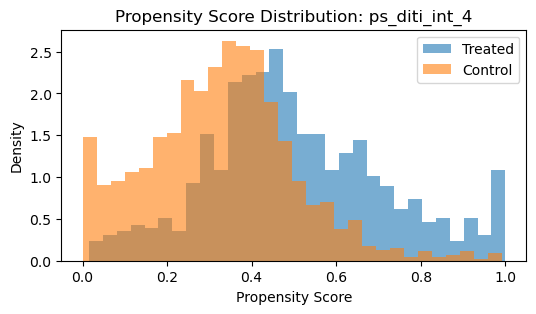


Top 5 WORST BEFORE MATCHING:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766

Top 5 WORST AFTER MATCHING:
                      SMD_after
fertilizer_indicator   0.133345
croparea               0.076003
fertilizer_frequency   0.075706
vdeepsoil_plotcount    0.075499
kharif                 0.071424

Experiment: diti | PS: ps_diti_int_scaled_4
ATT (Effect on yield) using ps_diti_int_scaled_4 (caliper=0.05): 6.467514437829664


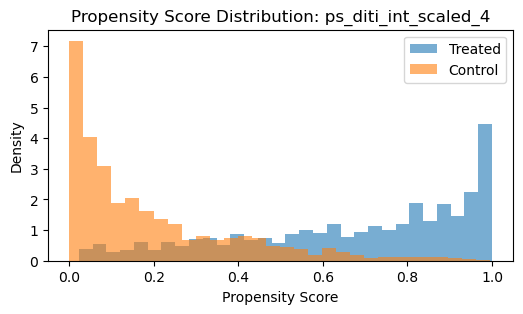


Top 5 WORST BEFORE MATCHING:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766

Top 5 WORST AFTER MATCHING:
                                SMD_after
alkaline_acidic_plotcount        0.109600
instance_formal_before_sorghum   0.095367
motorpa                          0.076029
erosive_plotcount                0.059946
nitropa                          0.058708

Experiment: ditf | PS: ps_ditf_dml_rf_cross
ATT (Effect on yield) using ps_ditf_dml_rf_cross (caliper=0.05): -10.926912862668871


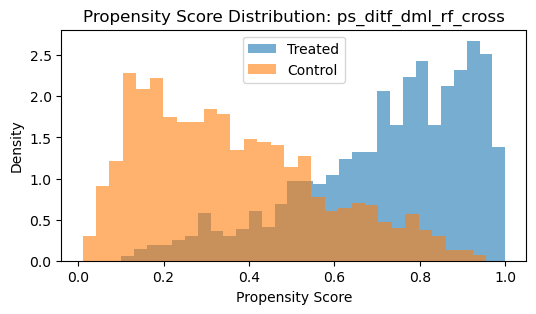


Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                           SMD_after
alkaline_acidic_plotcount   0.149944
fertilizer_frequency        0.136163
td_tot_real                 0.133949
phospa                      0.132317
wealth_index                0.129184

Experiment: ditf | PS: ps_ditf_dml_rf_nocross
ATT (Effect on yield) using ps_ditf_dml_rf_nocross (caliper=0.05): nan


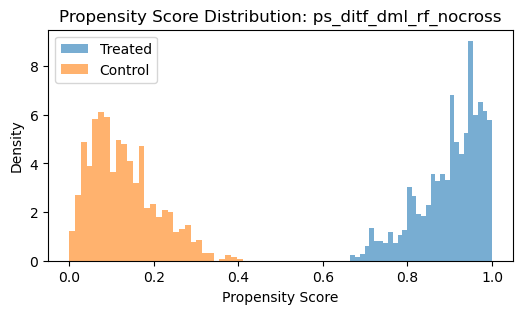

No matches found within caliper; skipping SMD after matching for this PS.

Experiment: diti | PS: ps_diti_dml_rf_cross
ATT (Effect on yield) using ps_diti_dml_rf_cross (caliper=0.05): -29.181687280836286


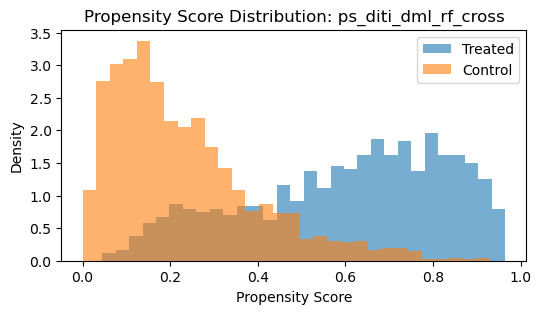


Top 5 WORST BEFORE MATCHING:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766

Top 5 WORST AFTER MATCHING:
                                  SMD_after
instance_informal_before_sorghum   0.218785
small                              0.208436
wealth_index                       0.162867
operationalland                    0.160976
intercropping_i                    0.138507

Experiment: diti | PS: ps_diti_dml_rf_nocross
ATT (Effect on yield) using ps_diti_dml_rf_nocross (caliper=0.05): nan


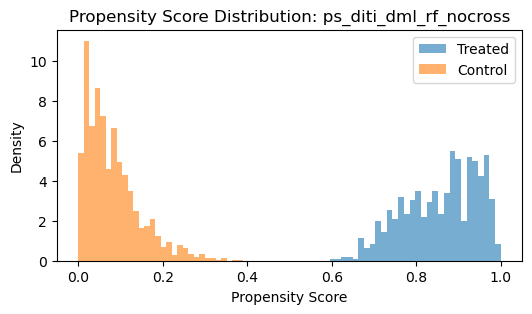

No matches found within caliper; skipping SMD after matching for this PS.


==== SUMMARY OF ALL ATT EFFECTS (Yield) - Caliper Matching ====

ps_ditf_1                            ATT(yield) = 2.769979977562002
ps_ditf_scaled_1                     ATT(yield) = 26.9154415814603
ps_diti_2                            ATT(yield) = -55.70016612297252
ps_diti_scaled_2                     ATT(yield) = -7.799336116180143
ps_ditf_int_3                        ATT(yield) = 79.19406795752678
ps_ditf_int_scaled_3                 ATT(yield) = -21.192587867425914
ps_diti_int_4                        ATT(yield) = -43.31242621518288
ps_diti_int_scaled_4                 ATT(yield) = 6.467514437829664
ps_ditf_dml_rf_cross                 ATT(yield) = -10.926912862668871
ps_ditf_dml_rf_nocross               ATT(yield) = nan
ps_diti_dml_rf_cross                 ATT(yield) = -29.181687280836286
ps_diti_dml_rf_nocross               ATT(yield) = nan

===== FINAL SUMMARY TABLE =====

            PS Model Treatmen

In [18]:
# ==============================================
# FULL END-TO-END PIPELINE (with CALIPER MATCHING)
# Paste & run this cell top-to-bottom in your notebook.
# Adjust CSV_PATH if needed. Results + plots + SMD table saved to disk.
# ==============================================

# 0) Imports
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

# If you want the uploaded file path (image) printed at the end:
UPLOADED_FILE_PATH = "/mnt/data/e1578f86-e49b-4e6e-89e8-66dd61214654.png"

# -------------------------
# 1) Load data
# -------------------------
CSV_PATH = "v4.csv"   # <-- change path if necessary
df = pd.read_csv(CSV_PATH)
print("Loaded df with shape:", df.shape)

# -------------------------
# 2) Baseline variable lists + helper functions (exact as your baseline)
# -------------------------
treat = "ditf"
treat2 = "diti"
temp_fix_ef = "year"

cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()

    # add pairwise interactions
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)

    # categorical dummies
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

    # year FE
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)

    # numeric conversion
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")

    return X

# -------------------------
# 3) Original logistic propensity fitting (keeps names from your baseline)
# -------------------------
def fit_pscore(df, treat_col, include_interaction=False, scaled=False):
    y = df[treat_col].astype(int)
    X = prepare_X(df, include_interaction)

    if scaled:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    lr = LogisticRegression(max_iter=10000)
    lr.fit(X, y)
    ps = lr.predict_proba(X)[:, 1]
    return lr, ps

# Compute original logistic PS columns (mirrors your earlier runs)
print("Fitting original logistic propensity models...")
model1_orig, ps1_orig = fit_pscore(df, treat, include_interaction=False, scaled=False)
model1_scaled, ps1_scaled = fit_pscore(df, treat, include_interaction=False, scaled=True)
df["ps_ditf_1"] = ps1_orig
df["ps_ditf_scaled_1"] = ps1_scaled
print("Experiment 1 (ditf) done")

model2_orig, ps2_orig = fit_pscore(df, treat2, include_interaction=False, scaled=False)
model2_scaled, ps2_scaled = fit_pscore(df, treat2, include_interaction=False, scaled=True)
df["ps_diti_2"] = ps2_orig
df["ps_diti_scaled_2"] = ps2_scaled
print("Experiment 2 (diti) done")

model3_orig, ps3_orig = fit_pscore(df, treat, include_interaction=True, scaled=False)
model3_scaled, ps3_scaled = fit_pscore(df, treat, include_interaction=True, scaled=True)
df["ps_ditf_int_3"] = ps3_orig
df["ps_ditf_int_scaled_3"] = ps3_scaled
print("Experiment 3 (ditf interactions) done")

model4_orig, ps4_orig = fit_pscore(df, treat2, include_interaction=True, scaled=False)
model4_scaled, ps4_scaled = fit_pscore(df, treat2, include_interaction=True, scaled=True)
df["ps_diti_int_4"] = ps4_orig
df["ps_diti_int_scaled_4"] = ps4_scaled
print("Experiment 4 (diti interactions) done")

# -------------------------
# 4) DML: cross-fitting implementation for ATE (out-of-fold p, m0, m1)
# -------------------------
def dml_ate_crossfit(
    df,
    treat_col,
    outcome_col="yield",
    X_cols=None,
    n_splits=5,
    prop_model=None,
    m_model_treated=None,
    m_model_control=None,
    random_state=42,
):
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    # default learners
    if prop_model is None:
        prop_model = RandomForestClassifier(n_estimators=200, random_state=random_state)
    if m_model_treated is None:
        m_model_treated = RandomForestRegressor(n_estimators=200, random_state=random_state)
    if m_model_control is None:
        m_model_control = RandomForestRegressor(n_estimators=200, random_state=random_state)

    n = df.shape[0]
    p_oof = np.zeros(n)
    m0_oof = np.zeros(n)
    m1_oof = np.zeros(n)

    X_full = df[X_cols].copy()
    # scale numeric features for ML
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    X_use = pd.DataFrame(X_scaled, columns=X_cols, index=df.index)

    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(X_use):
        X_tr = X_use.iloc[train_idx]
        X_te = X_use.iloc[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # propensity
        prop_model.fit(X_tr, t_tr)
        p_hat = prop_model.predict_proba(X_te)[:, 1]
        p_oof[test_idx] = p_hat

        # outcome models: fit on treated/control in train
        treat_mask = (t_tr == 1)
        ctrl_mask = (t_tr == 0)
        # handle small-sample corner cases:
        if np.sum(treat_mask) < 5 or np.sum(ctrl_mask) < 5:
            # fallback: single regressor with T as feature
            alt = RandomForestRegressor(n_estimators=100, random_state=random_state)
            X_tr_alt = X_tr.copy()
            X_tr_alt['T_flag'] = t_tr
            alt.fit(X_tr_alt, y_tr)
            X_te_alt1 = X_te.copy(); X_te_alt1['T_flag'] = 1
            X_te_alt0 = X_te.copy(); X_te_alt0['T_flag'] = 0
            m1_oof[test_idx] = alt.predict(X_te_alt1)
            m0_oof[test_idx] = alt.predict(X_te_alt0)
        else:
            m_model_treated.fit(X_tr.loc[treat_mask], y_tr[treat_mask])
            m_model_control.fit(X_tr.loc[ctrl_mask], y_tr[ctrl_mask])
            m1_oof[test_idx] = m_model_treated.predict(X_te)
            m0_oof[test_idx] = m_model_control.predict(X_te)

    # clip p
    eps = 1e-6
    p_oof = np.clip(p_oof, eps, 1 - eps)

    # influence function for ATE
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_oof, "m0_oof": m0_oof, "m1_oof": m1_oof}

# No-crossfit (train on all, evaluate on all) baseline
def dml_ate_no_crossfit(df, treat_col, outcome_col="yield", X_cols=None, random_state=42):
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    X_full = df[X_cols].copy()
    scaler = StandardScaler()
    X_use = pd.DataFrame(scaler.fit_transform(X_full), columns=X_cols, index=df.index)

    prop = RandomForestClassifier(n_estimators=200, random_state=random_state)
    m_t = RandomForestRegressor(n_estimators=200, random_state=random_state)
    m_c = RandomForestRegressor(n_estimators=200, random_state=random_state)

    t = df[treat_col].astype(int).values
    y = df[outcome_col].values

    prop.fit(X_use, t)
    p_hat = prop.predict_proba(X_use)[:, 1]
    p_hat = np.clip(p_hat, 1e-6, 1 - 1e-6)

    # fit outcome models on treated/control
    if np.sum(t == 1) < 5 or np.sum(t == 0) < 5:
        # fallback combined
        alt = RandomForestRegressor(n_estimators=100, random_state=random_state)
        X_withT = X_use.copy(); X_withT['T_flag'] = t
        alt.fit(X_withT, y)
        X1 = X_use.copy(); X1['T_flag'] = 1
        X0 = X_use.copy(); X0['T_flag'] = 0
        m1_hat = alt.predict(X1)
        m0_hat = alt.predict(X0)
    else:
        m_t.fit(X_use.loc[df[treat_col] == 1], df.loc[df[treat_col] == 1, outcome_col])
        m_c.fit(X_use.loc[df[treat_col] == 0], df.loc[df[treat_col] == 0, outcome_col])
        m1_hat = m_t.predict(X_use)
        m0_hat = m_c.predict(X_use)

    psi = (m1_hat - m0_hat) + (t * (y - m1_hat) / p_hat) - ((1 - t) * (y - m0_hat) / (1 - p_hat))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))
    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_hat, "m0_oof": m0_hat, "m1_oof": m1_hat}

# -------------------------
# 5) Run DML experiments for both treatments and save PS columns
# -------------------------
print("\nRunning DML cross-fit (RF) for ditf...")
# build X_cols identical to prepare_X(include_interaction=False)
X_all = prepare_X(df, include_interaction=False)
X_cols = X_all.columns.tolist()
# Attach X_all columns to df temporarily (used by some matchers later)
for c in X_cols:
    df[c] = X_all[c]

# DML crossfit (RF baseline)
res_ditf_rf = dml_ate_crossfit(df, treat_col="ditf", outcome_col="yield", X_cols=X_cols, n_splits=5)
df["ps_ditf_dml_rf_cross"] = res_ditf_rf["p_oof"]
df["m0_ditf_dml_rf_cross"] = res_ditf_rf["m0_oof"]
df["m1_ditf_dml_rf_cross"] = res_ditf_rf["m1_oof"]

# DML no-crossfit
res_ditf_rf_nocf = dml_ate_no_crossfit(df, treat_col="ditf", outcome_col="yield", X_cols=X_cols)
df["ps_ditf_dml_rf_nocross"] = res_ditf_rf_nocf["p_oof"]

print("DML (ditf) ATE (crossfit RF):", res_ditf_rf["ATE"], "SE:", res_ditf_rf["ATE_se"])
print("DML (ditf) ATE (no-crossfit RF):", res_ditf_rf_nocf["ATE"], "SE:", res_ditf_rf_nocf["ATE_se"])

print("\nRunning DML cross-fit (RF) for diti...")
res_diti_rf = dml_ate_crossfit(df, treat_col="diti", outcome_col="yield", X_cols=X_cols, n_splits=5)
df["ps_diti_dml_rf_cross"] = res_diti_rf["p_oof"]
df["m0_diti_dml_rf_cross"] = res_diti_rf["m0_oof"]
df["m1_diti_dml_rf_cross"] = res_diti_rf["m1_oof"]

res_diti_rf_nocf = dml_ate_no_crossfit(df, treat_col="diti", outcome_col="yield", X_cols=X_cols)
df["ps_diti_dml_rf_nocross"] = res_diti_rf_nocf["p_oof"]

print("DML (diti) ATE (crossfit RF):", res_diti_rf["ATE"], "SE:", res_diti_rf["ATE_se"])
print("DML (diti) ATE (no-crossfit RF):", res_diti_rf_nocf["ATE"], "SE:", res_diti_rf_nocf["ATE_se"])

# -------------------------
# 6) Caliper matching function (user-supplied) - replaces nearest neighbor matching
# -------------------------
def caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05):
    """
    1:1 Caliper Matching version of your NN matching.
    Matches each treated unit to the closest control unit within caliper distance.

    Returns:
        att, treated_matched (DataFrame), control_matched (DataFrame), df2 (used)
    """
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1].copy()
    control = df2[df2[treat_col] == 0].copy()

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None, df2

    matched_treated = []
    matched_control = []

    used_controls = set()

    # Loop over treated in sorted order
    for i, row in treated.iterrows():
        t_ps = row[ps_col]

        # Eligible controls within caliper and not used
        eligible = control[
            (control[ps_col] >= t_ps - caliper) &
            (control[ps_col] <= t_ps + caliper) &
            (~control.index.isin(used_controls))
        ]

        if eligible.empty:
            continue

        # Select control with minimal |ps_treated - ps_control|
        idx = (eligible[ps_col] - t_ps).abs().idxmin()

        matched_treated.append(row)
        matched_control.append(eligible.loc[idx])
        used_controls.add(idx)

    if len(matched_treated) == 0:
        return np.nan, None, None, df2

    treated_m = pd.DataFrame(matched_treated).reset_index(drop=False)
    control_m = pd.DataFrame(matched_control).reset_index(drop=False)

    att = treated_m[outcome].mean() - control_m[outcome].mean()

    return att, treated_m, control_m, df2

# -------------------------
# 7) Run caliper matching across all PS variants, compute ATT and SMDs
# -------------------------
# list of PSs (add / remove as needed)
experiments = [
    ("ditf", "ps_ditf_1"),
    ("ditf", "ps_ditf_scaled_1"),
    ("diti", "ps_diti_2"),
    ("diti", "ps_diti_scaled_2"),
    ("ditf", "ps_ditf_int_3"),
    ("ditf", "ps_ditf_int_scaled_3"),
    ("diti", "ps_diti_int_4"),
    ("diti", "ps_diti_int_scaled_4"),
    ("ditf", "ps_ditf_dml_rf_cross"),
    ("ditf", "ps_ditf_dml_rf_nocross"),
    ("diti", "ps_diti_dml_rf_cross"),
    ("diti", "ps_diti_dml_rf_nocross"),
]

# SMD helpers
def compute_smd(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0 or np.isnan(pooled_sd):
        return np.nan
    return abs(mean_t - mean_c) / pooled_sd

def smd_before_matching(df, treat_col, covariates):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd_dict = {}
    for col in covariates:
        if col in df.columns:
            smd_dict[col] = compute_smd(treated, control, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])

def smd_after_matching(treated_matched, control_matched, covariates):
    smd_dict = {}
    for col in covariates:
        if col in treated_matched.columns and col in control_matched.columns:
            smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])

results = []
smd_results = {}

print("\nRunning caliper matching for each PS variant and plotting distributions...")
for treat_col, ps_col in experiments:
    if ps_col not in df.columns:
        print(f"Warning: {ps_col} not found in df columns; skipping.")
        results.append((ps_col, np.nan))
        continue

    print("\n==============================")
    print(f"Experiment: {treat_col} | PS: {ps_col}")
    print("==============================")

    att, treated_m, control_m, df2 = caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05)
    results.append((ps_col, att))
    print(f"ATT (Effect on yield) using {ps_col} (caliper=0.05): {att}")

    # PS distribution plot (treated vs control)
    plt.figure(figsize=(6,3))
    plt.hist(df.loc[df[treat_col]==1, ps_col].dropna(), bins=30, alpha=0.6, density=True, label="Treated")
    plt.hist(df.loc[df[treat_col]==0, ps_col].dropna(), bins=30, alpha=0.6, density=True, label="Control")
    plt.title(f"Propensity Score Distribution: {ps_col}")
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # compute smd before/after for this ps_col
    smd_b = smd_before_matching(df, treat_col, other_cols)
    if treated_m is None or control_m is None:
        print("No matches found within caliper; skipping SMD after matching for this PS.")
        continue

    # Note: treated_m and control_m are small DataFrames built from matched rows; ensure their columns include covariates
    # If prepare_X columns were attached to df earlier, those columns are present. We will use original covariates in other_cols.
    # treated_m and control_m here have original covariates because caliper_match used df[[...]+other_cols]
    smd_a = smd_after_matching(treated_m, control_m, other_cols)
    smd_results[ps_col] = (smd_b, smd_a)

    print("\nTop 5 WORST BEFORE MATCHING:")
    print(smd_b.sort_values("SMD_before", ascending=False).head())

    print("\nTop 5 WORST AFTER MATCHING:")
    print(smd_a.sort_values("SMD_after", ascending=False).head())

# Summary table of ATT
print("\n\n==== SUMMARY OF ALL ATT EFFECTS (Yield) - Caliper Matching ====\n")
for ps_col, att in results:
    print(f"{ps_col:<35}  ATT(yield) = {att}")

# -------------------------
# 8) Build SMD summary table in the screenshot format
# -------------------------
def classify_model(max_smd):
    if np.isnan(max_smd):
        return "No matches"
    if max_smd <= 0.15:
        return "Best"
    elif max_smd <= 0.20:
        return "Good"
    elif max_smd <= 0.25:
        return "Acceptable"
    elif max_smd <= 0.30:
        return "Weak"
    elif max_smd <= 0.35:
        return "Poor"
    else:
        return "Worst"

summary_rows = []
for ps_col, pair in smd_results.items():
    smd_b, smd_a = pair
    max_smd_after = smd_a["SMD_after"].dropna().max() if smd_a is not None else np.nan
    treatment = "ditf" if "ditf" in ps_col else "diti"
    interaction = "Yes" if "int" in ps_col else "No"
    scaled = "Yes" if "scaled" in ps_col else "No"
    verdict = classify_model(max_smd_after)
    summary_rows.append({
        "PS Model": ps_col,
        "Treatment": treatment,
        "Interaction": interaction,
        "Scaled": scaled,
        "Max SMD_after": round(max_smd_after, 3) if not np.isnan(max_smd_after) else np.nan,
        "Verdict": verdict
    })

summary_table = pd.DataFrame(summary_rows)
summary_table = summary_table.sort_values("Max SMD_after")
print("\n===== FINAL SUMMARY TABLE =====\n")
print(summary_table.to_string(index=False))

# Save to CSV for your report
summary_table.to_csv("ps_model_smd_summary_table_caliper.csv", index=False)
print("\nSaved as: ps_model_smd_summary_table_caliper.csv")

# -------------------------
# 9) Save SMD details for each PS to CSVs (for thorough reporting)
# -------------------------
for ps_col, (smd_b, smd_a) in smd_results.items():
    outname = f"smd_details_{ps_col}.csv"
    df_out = smd_b.join(smd_a, how="outer")
    df_out.to_csv(outname)
    # no print to avoid too much clutter

# -------------------------
# 10) Save df with PS columns
# -------------------------
OUT_PATH = "v4_with_ps_caliper.csv"
df.to_csv(OUT_PATH, index=False)
print(f"\nDataframe with PS columns saved to: {OUT_PATH}")

# Print the uploaded file path (image) so you can reference it in your report
print("\nUploaded file path (image):", UPLOADED_FILE_PATH)


## Cross fit analysis

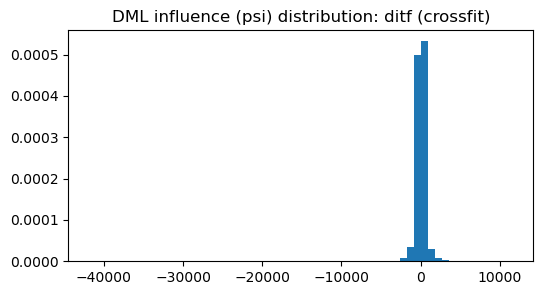

psi mean, sd, min, max: 2.8803878554237636 1172.8816400044236 -41810.17527024583 11595.64470167603
num |psi| > 3*sd: 17


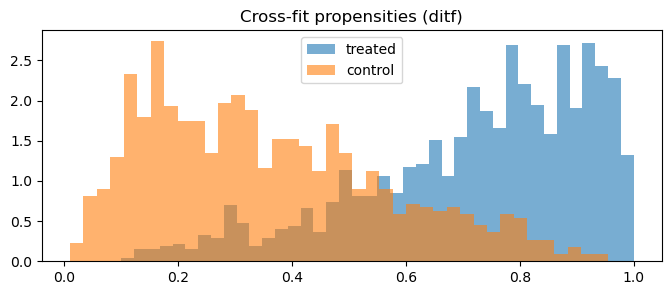

In [19]:
# psi = res_ditf_rf['psi']  # from your DML output
import matplotlib.pyplot as plt
import numpy as np

# plot psi distribution (ditf)
psi = res_ditf_rf['psi']
plt.figure(figsize=(6,3))
plt.hist(psi, bins=60, density=True)
plt.title("DML influence (psi) distribution: ditf (crossfit)")
plt.show()

# extreme psi values
print("psi mean, sd, min, max:", np.nanmean(psi), np.nanstd(psi), np.nanmin(psi), np.nanmax(psi))
print("num |psi| > 3*sd:", np.sum(np.abs(psi) > 3*np.nanstd(psi)))

# plot propensities by treatment
p = res_ditf_rf['p_oof']
plt.figure(figsize=(8,3))
plt.hist(p[df['ditf']==1], bins=40, alpha=0.6, label='treated', density=True)
plt.hist(p[df['ditf']==0], bins=40, alpha=0.6, label='control', density=True)
plt.legend(); plt.title("Cross-fit propensities (ditf)"); plt.show()


Loaded df with shape: (2151, 36)
Fitting original logistic propensity models...
Logistic PS fits done.

Running DML cross-fit with per-fold tuning for 'ditf' ...
Fold 1/5 done in 13.6s (train size 1720)
Fold 2/5 done in 9.9s (train size 1721)
Fold 3/5 done in 9.8s (train size 1721)
Fold 4/5 done in 8.9s (train size 1721)
Fold 5/5 done in 10.2s (train size 1721)
Total cross-fit tuning time: 52.5s
DML (ditf) tuned crossfit ATE: 13.694126016969935 SE: 25.05694122835689

Running DML no-crossfit tuned baseline for 'ditf' ...
DML (ditf) tuned no-crossfit ATE: 30.684544742025924 SE: 10.801692271244157

Running DML cross-fit with per-fold tuning for 'diti' ...
Fold 1/5 done in 10.3s (train size 1720)
Fold 2/5 done in 11.2s (train size 1721)
Fold 3/5 done in 10.8s (train size 1721)
Fold 4/5 done in 10.7s (train size 1721)
Fold 5/5 done in 11.9s (train size 1721)
Total cross-fit tuning time: 54.9s
DML (diti) tuned crossfit ATE: -32.26825296869081 SE: 13.570410645221418

Running DML no-crossfit t

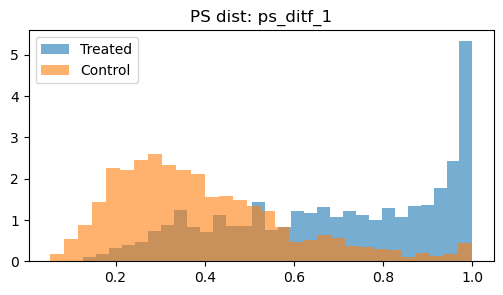

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                                SMD_after
deepsoil_plotcount               0.059473
problemsoil_plotcount            0.059064
fertilizer_indicator             0.054771
local_seed                       0.054107
instance_formal_before_sorghum   0.053773

----------------------------
ps_ditf_scaled_1 (ditf)
ATT (caliper match) for ps_ditf_scaled_1: 26.9154415814603


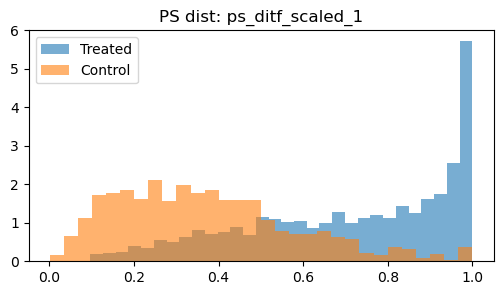

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                                  SMD_after
operationalland                    0.085003
instance_informal_before_sorghum   0.073243
plotcount                          0.068439
croparea                           0.054796
small                              0.053492

----------------------------
ps_diti_2 (diti)
ATT (caliper match) for ps_diti_2: -55.70016612297252


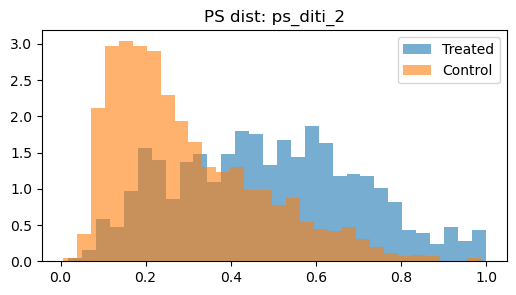

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                           SMD_after
alkaline_acidic_plotcount   0.081794
operationalland             0.060772
motorpa                     0.057035
sc_st_nt                    0.053685
plotcount                   0.051835

----------------------------
ps_diti_scaled_2 (diti)
ATT (caliper match) for ps_diti_scaled_2: -7.799336116180143


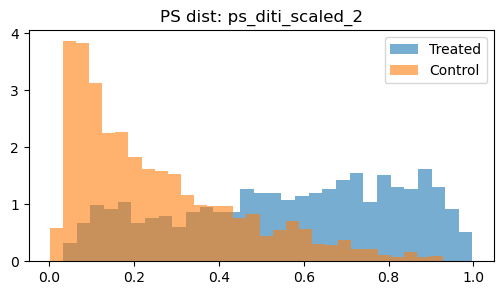

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                                SMD_after
nitropa                          0.061159
fertilizer_indicator             0.060181
potashpa                         0.057320
instance_formal_before_sorghum   0.038581
plotcount                        0.035584

----------------------------
ps_ditf_int_3 (ditf)
ATT (caliper match) for ps_ditf_int_3: 79.19406795752678


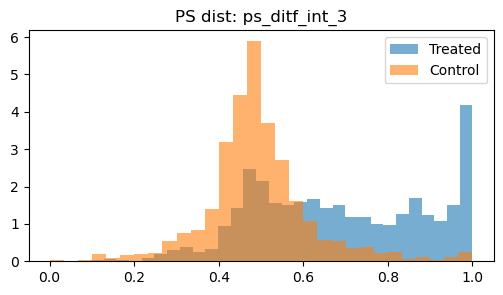

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                                  SMD_after
operationalland                    0.194229
croparea                           0.181104
kharif                             0.155923
fertilizer_indicator               0.151806
instance_informal_before_sorghum   0.141755

----------------------------
ps_ditf_int_scaled_3 (ditf)
ATT (caliper match) for ps_ditf_int_scaled_3: -21.192587867425914


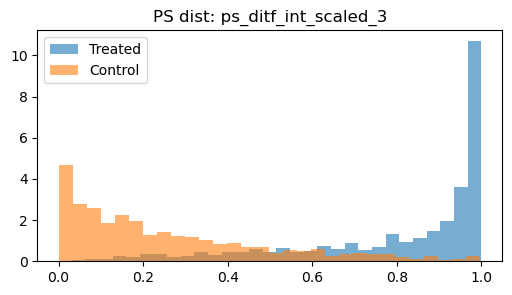

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                                  SMD_after
td_tot_real                        0.136585
wealth_index                       0.107115
fertilizer_indicator               0.098811
instance_informal_before_sorghum   0.093667
nitropa                            0.088243

----------------------------
ps_diti_int_4 (diti)
ATT (caliper match) for ps_diti_int_4: -43.31242621518288


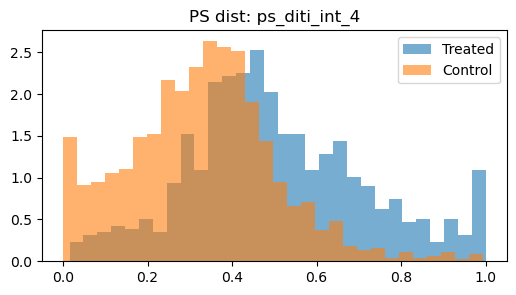

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                      SMD_after
fertilizer_indicator   0.133345
croparea               0.076003
fertilizer_frequency   0.075706
vdeepsoil_plotcount    0.075499
kharif                 0.071424

----------------------------
ps_diti_int_scaled_4 (diti)
ATT (caliper match) for ps_diti_int_scaled_4: 6.467514437829664


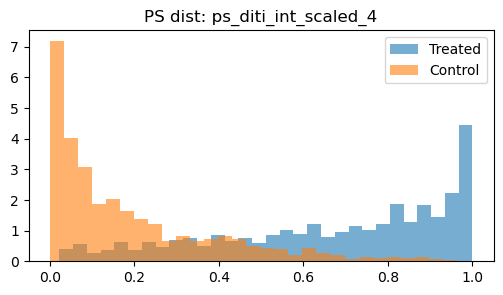

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                                SMD_after
alkaline_acidic_plotcount        0.109600
instance_formal_before_sorghum   0.095367
motorpa                          0.076029
erosive_plotcount                0.059946
nitropa                          0.058708

----------------------------
ps_ditf_dml_rf_cross_tuned (ditf)
ATT (caliper match) for ps_ditf_dml_rf_cross_tuned: 18.47462830523483


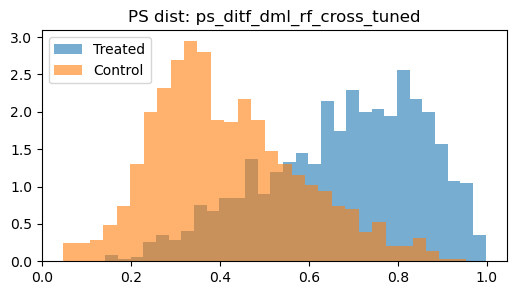

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                       SMD_after
td_tot_real             0.236169
wealth_index            0.195724
problemsoil_plotcount   0.185351
small                   0.177133
fertilizer_frequency    0.157031

----------------------------
ps_ditf_dml_rf_nocross_tuned (ditf)
ATT (caliper match) for ps_ditf_dml_rf_nocross_tuned: -20.068279853560455


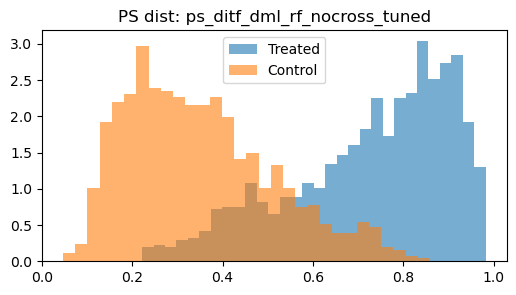

Top 5 before:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
Top 5 after:
                                  SMD_after
wealth_index                       0.483494
td_tot_real                        0.410565
instance_informal_before_sorghum   0.374544
small                              0.355216
fertilizer_indicator               0.339441

----------------------------
ps_diti_dml_rf_cross_tuned (diti)
ATT (caliper match) for ps_diti_dml_rf_cross_tuned: -82.77086680451617


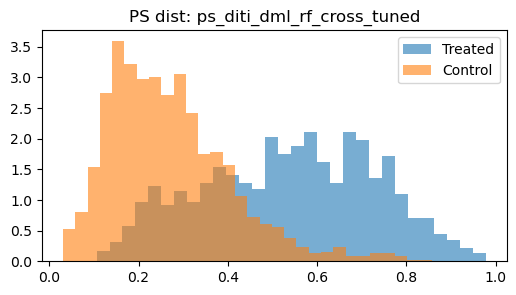

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                                  SMD_after
fertilizer_indicator               0.378632
nitropa                            0.319193
instance_informal_before_sorghum   0.274331
phospa                             0.244245
wealth_index                       0.237048

----------------------------
ps_diti_dml_rf_nocross_tuned (diti)
ATT (caliper match) for ps_diti_dml_rf_nocross_tuned: -69.47644026162192


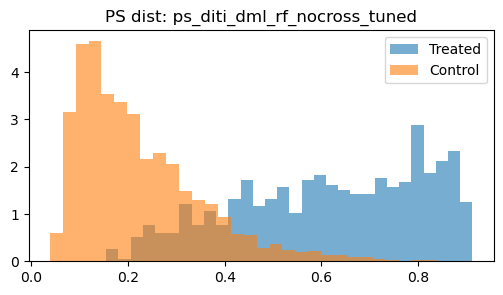

Top 5 before:
                                SMD_before
fertilizer_indicator              0.485307
instance_formal_before_sorghum    0.475267
fertilizer_frequency              0.366406
kharif                            0.362938
motorpa                           0.304766
Top 5 after:
                                  SMD_after
fertilizer_indicator               0.594031
fertilizer_frequency               0.498841
instance_informal_before_sorghum   0.414117
kharif                             0.374818
wealth_index                       0.361055

All ATT results (caliper):
ps_ditf_1                           ATT = 2.769979977562002
ps_ditf_scaled_1                    ATT = 26.9154415814603
ps_diti_2                           ATT = -55.70016612297252
ps_diti_scaled_2                    ATT = -7.799336116180143
ps_ditf_int_3                       ATT = 79.19406795752678
ps_ditf_int_scaled_3                ATT = -21.192587867425914
ps_diti_int_4                       ATT = -43.31242621518288

In [20]:
# ============================
# END-TO-END PIPELINE WITH RF HYPERPARAMETER TUNING INSIDE CROSS-FIT
# Paste & run in a notebook cell (do not run pieces out of order).
# ============================

# 0) Imports
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, log_loss, mean_squared_error
import scipy.stats as stats
import time

# -------------------------
# 1) Load data
# -------------------------
CSV_PATH = "v4.csv"   # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded df with shape:", df.shape)

# -------------------------
# 2) Baseline variable lists + helper functions
# -------------------------
treat = "ditf"
treat2 = "diti"
temp_fix_ef = "year"

cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")
    return X

# -------------------------
# 3) Original logistic propensity fitting (like baseline)
# -------------------------
def fit_pscore(df, treat_col, include_interaction=False, scaled=False):
    y = df[treat_col].astype(int)
    X = prepare_X(df, include_interaction)
    if scaled:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X, y)
    ps = lr.predict_proba(X)[:, 1]
    return lr, ps

print("Fitting original logistic propensity models...")
model1_orig, ps1_orig = fit_pscore(df, treat, include_interaction=False, scaled=False)
model1_scaled, ps1_scaled = fit_pscore(df, treat, include_interaction=False, scaled=True)
df["ps_ditf_1"] = ps1_orig
df["ps_ditf_scaled_1"] = ps1_scaled

model2_orig, ps2_orig = fit_pscore(df, treat2, include_interaction=False, scaled=False)
model2_scaled, ps2_scaled = fit_pscore(df, treat2, include_interaction=False, scaled=True)
df["ps_diti_2"] = ps2_orig
df["ps_diti_scaled_2"] = ps2_scaled

model3_orig, ps3_orig = fit_pscore(df, treat, include_interaction=True, scaled=False)
model3_scaled, ps3_scaled = fit_pscore(df, treat, include_interaction=True, scaled=True)
df["ps_ditf_int_3"] = ps3_orig
df["ps_ditf_int_scaled_3"] = ps3_scaled

model4_orig, ps4_orig = fit_pscore(df, treat2, include_interaction=True, scaled=False)
model4_scaled, ps4_scaled = fit_pscore(df, treat2, include_interaction=True, scaled=True)
df["ps_diti_int_4"] = ps4_orig
df["ps_diti_int_scaled_4"] = ps4_scaled

print("Logistic PS fits done.")

# -------------------------
# 4) Helper: RF tuning utilities (RandomizedSearchCV)
#    These will be used inside cross-fit folds (tuning only on train fold).
# -------------------------
def get_rf_classifier_search(n_iter=20, random_state=0, n_jobs=-1):
    param_dist = {
        'n_estimators': stats.randint(100, 400),
        'max_depth': [None] + list(range(3, 21)),
        'min_samples_split': stats.randint(2, 11),
        'min_samples_leaf': stats.randint(1, 11),
        'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8]
    }
    rf = RandomForestClassifier(random_state=random_state)
    # use log-loss as scoring for propensity classification
    scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=n_iter,
                            scoring=scorer, cv=3, random_state=random_state, n_jobs=n_jobs, verbose=0)
    return rs

def get_rf_regressor_search(n_iter=20, random_state=0, n_jobs=-1):
    param_dist = {
        'n_estimators': stats.randint(100, 400),
        'max_depth': [None] + list(range(3, 21)),
        'min_samples_split': stats.randint(2, 11),
        'min_samples_leaf': stats.randint(1, 11),
        'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8]
    }
    rf = RandomForestRegressor(random_state=random_state)
    # use neg MSE as scoring for regressor
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=n_iter,
                            scoring=scorer, cv=3, random_state=random_state, n_jobs=n_jobs, verbose=0)
    return rs

# -------------------------
# 5) DML cross-fit with tuning inside each fold
# -------------------------
def dml_ate_crossfit_tuned(
    df,
    treat_col,
    outcome_col="yield",
    X_cols=None,
    n_splits=5,
    random_state=42,
    tune_iter=25,
    n_jobs=-1
):
    """
    Cross-fitted DML where Random Forest nuisance models are hyperparameter-tuned
    *within each train fold* using RandomizedSearchCV (no leakage to test fold).
    """
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    n = df.shape[0]
    p_oof = np.zeros(n)
    m0_oof = np.zeros(n)
    m1_oof = np.zeros(n)

    X_full = df[X_cols].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    X_use = pd.DataFrame(X_scaled, columns=X_cols, index=df.index)

    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold = 0
    start_all = time.time()
    for train_idx, test_idx in kf.split(X_use):
        fold += 1
        t0 = time.time()
        X_tr = X_use.iloc[train_idx]
        X_te = X_use.iloc[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # ---- propensity: tune classifier on train set ----
        rs_prop = get_rf_classifier_search(n_iter=tune_iter, random_state=random_state+fold, n_jobs=n_jobs)
        rs_prop.fit(X_tr, t_tr)
        best_prop = rs_prop.best_estimator_
        p_hat = best_prop.predict_proba(X_te)[:, 1]
        p_oof[test_idx] = p_hat

        # ---- outcome models: tune regressors on treated/control subsets of TRAIN ----
        # treated regressor
        treat_mask = (t_tr == 1)
        ctrl_mask = (t_tr == 0)

        # If insufficient treated/control in fold train, fall back to combined approach
        if np.sum(treat_mask) < 5 or np.sum(ctrl_mask) < 5:
            # combined regressor with T flag
            rs_alt = get_rf_regressor_search(n_iter=max(10, tune_iter//2), random_state=random_state+fold, n_jobs=n_jobs)
            X_tr_alt = X_tr.copy()
            X_tr_alt['T_flag'] = t_tr
            rs_alt.fit(X_tr_alt, y_tr)
            best_alt = rs_alt.best_estimator_
            X_te_alt1 = X_te.copy(); X_te_alt1['T_flag'] = 1
            X_te_alt0 = X_te.copy(); X_te_alt0['T_flag'] = 0
            m1_oof[test_idx] = best_alt.predict(X_te_alt1)
            m0_oof[test_idx] = best_alt.predict(X_te_alt0)
        else:
            # tune regressor for treated
            rs_mt = get_rf_regressor_search(n_iter=tune_iter, random_state=random_state+fold*2, n_jobs=n_jobs)
            rs_mc = get_rf_regressor_search(n_iter=tune_iter, random_state=random_state+fold*3, n_jobs=n_jobs)
            rs_mt.fit(X_tr.loc[treat_mask], y_tr[treat_mask])
            rs_mc.fit(X_tr.loc[ctrl_mask], y_tr[ctrl_mask])
            best_mt = rs_mt.best_estimator_
            best_mc = rs_mc.best_estimator_
            m1_oof[test_idx] = best_mt.predict(X_te)
            m0_oof[test_idx] = best_mc.predict(X_te)

        t1 = time.time()
        print(f"Fold {fold}/{n_splits} done in {t1-t0:.1f}s (train size {len(train_idx)})")

    total_time = time.time() - start_all
    print(f"Total cross-fit tuning time: {total_time:.1f}s")

    # Clip p
    eps = 1e-6
    p_oof = np.clip(p_oof, eps, 1 - eps)

    # Influence function for ATE
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_oof, "m0_oof": m0_oof, "m1_oof": m1_oof}

# -------------------------
# 6) No-crossfit baseline with hyperparameter tuning on full sample (still useful for contrast)
# -------------------------
def dml_ate_no_crossfit_tuned(df, treat_col, outcome_col="yield", X_cols=None, tune_iter=50, random_state=42, n_jobs=-1):
    if X_cols is None:
        X_cols = [c for c in df.columns if c not in [treat_col, outcome_col]]

    X_full = df[X_cols].copy()
    scaler = StandardScaler()
    X_use = pd.DataFrame(scaler.fit_transform(X_full), columns=X_cols, index=df.index)

    t = df[treat_col].astype(int).values
    y = df[outcome_col].values

    # tune propensity on full sample
    rs_prop = get_rf_classifier_search(n_iter=tune_iter, random_state=random_state, n_jobs=n_jobs)
    rs_prop.fit(X_use, t)
    prop_best = rs_prop.best_estimator_
    p_hat = prop_best.predict_proba(X_use)[:,1]
    p_hat = np.clip(p_hat, 1e-6, 1-1e-6)

    # tune outcome regressors on full sample (treated/control)
    if np.sum(t==1) < 5 or np.sum(t==0) < 5:
        rs_alt = get_rf_regressor_search(n_iter=max(10, tune_iter//2), random_state=random_state, n_jobs=n_jobs)
        X_withT = X_use.copy(); X_withT['T_flag'] = t
        rs_alt.fit(X_withT, y)
        best_alt = rs_alt.best_estimator_
        X1 = X_use.copy(); X1['T_flag'] = 1
        X0 = X_use.copy(); X0['T_flag'] = 0
        m1_hat = best_alt.predict(X1)
        m0_hat = best_alt.predict(X0)
    else:
        rs_mt = get_rf_regressor_search(n_iter=tune_iter, random_state=random_state+1, n_jobs=n_jobs)
        rs_mc = get_rf_regressor_search(n_iter=tune_iter, random_state=random_state+2, n_jobs=n_jobs)
        rs_mt.fit(X_use.loc[df[treat_col]==1], df.loc[df[treat_col]==1, outcome_col])
        rs_mc.fit(X_use.loc[df[treat_col]==0], df.loc[df[treat_col]==0, outcome_col])
        m1_hat = rs_mt.best_estimator_.predict(X_use)
        m0_hat = rs_mc.best_estimator_.predict(X_use)

    psi = (m1_hat - m0_hat) + (t * (y - m1_hat) / p_hat) - ((1 - t) * (y - m0_hat) / (1 - p_hat))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "psi": psi, "p_oof": p_hat, "m0_oof": m0_hat, "m1_oof": m1_hat}

# -------------------------
# 7) Run tuned DML for both treatments (use moderate tune_iter to keep runtime reasonable)
# -------------------------
X_all = prepare_X(df, include_interaction=False)
X_cols = X_all.columns.tolist()
for c in X_cols:
    df[c] = X_all[c]

# Tune settings (reduce tune_iter if runtime is long)
N_SPLITS = 5
TUNE_ITER_FOLD = 20   # number of RandomizedSearchCV iterations inside each fold (reduce to 10 for faster runs)
TUNE_ITER_FULL = 50   # tuning iterations for no-crossfit baseline

print("\nRunning DML cross-fit with per-fold tuning for 'ditf' ...")
res_ditf_tuned = dml_ate_crossfit_tuned(df, treat_col="ditf", outcome_col="yield",
                                       X_cols=X_cols, n_splits=N_SPLITS,
                                       random_state=42, tune_iter=TUNE_ITER_FOLD, n_jobs=-1)
df["ps_ditf_dml_rf_cross_tuned"] = res_ditf_tuned["p_oof"]
df["m0_ditf_dml_rf_cross_tuned"] = res_ditf_tuned["m0_oof"]
df["m1_ditf_dml_rf_cross_tuned"] = res_ditf_tuned["m1_oof"]
print("DML (ditf) tuned crossfit ATE:", res_ditf_tuned["ATE"], "SE:", res_ditf_tuned["ATE_se"])

print("\nRunning DML no-crossfit tuned baseline for 'ditf' ...")
res_ditf_nocf_tuned = dml_ate_no_crossfit_tuned(df, treat_col="ditf", outcome_col="yield",
                                               X_cols=X_cols, tune_iter=TUNE_ITER_FULL, random_state=42, n_jobs=-1)
df["ps_ditf_dml_rf_nocross_tuned"] = res_ditf_nocf_tuned["p_oof"]
print("DML (ditf) tuned no-crossfit ATE:", res_ditf_nocf_tuned["ATE"], "SE:", res_ditf_nocf_tuned["ATE_se"])

print("\nRunning DML cross-fit with per-fold tuning for 'diti' ...")
res_diti_tuned = dml_ate_crossfit_tuned(df, treat_col="diti", outcome_col="yield",
                                       X_cols=X_cols, n_splits=N_SPLITS,
                                       random_state=42, tune_iter=TUNE_ITER_FOLD, n_jobs=-1)
df["ps_diti_dml_rf_cross_tuned"] = res_diti_tuned["p_oof"]
df["m0_diti_dml_rf_cross_tuned"] = res_diti_tuned["m0_oof"]
df["m1_diti_dml_rf_cross_tuned"] = res_diti_tuned["m1_oof"]
print("DML (diti) tuned crossfit ATE:", res_diti_tuned["ATE"], "SE:", res_diti_tuned["ATE_se"])

print("\nRunning DML no-crossfit tuned baseline for 'diti' ...")
res_diti_nocf_tuned = dml_ate_no_crossfit_tuned(df, treat_col="diti", outcome_col="yield",
                                               X_cols=X_cols, tune_iter=TUNE_ITER_FULL, random_state=42, n_jobs=-1)
df["ps_diti_dml_rf_nocross_tuned"] = res_diti_nocf_tuned["p_oof"]
print("DML (diti) tuned no-crossfit ATE:", res_diti_nocf_tuned["ATE"], "SE:", res_diti_nocf_tuned["ATE_se"])

# -------------------------
# 8) Caliper matching function (as you supplied)
# -------------------------
def caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05):
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1].copy()
    control = df2[df2[treat_col] == 0].copy()

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None, df2

    matched_treated = []
    matched_control = []
    used_controls = set()

    for i, row in treated.iterrows():
        t_ps = row[ps_col]
        eligible = control[
            (control[ps_col] >= t_ps - caliper) &
            (control[ps_col] <= t_ps + caliper) &
            (~control.index.isin(used_controls))
        ]
        if eligible.empty:
            continue
        idx = (eligible[ps_col] - t_ps).abs().idxmin()
        matched_treated.append(row)
        matched_control.append(eligible.loc[idx])
        used_controls.add(idx)

    if len(matched_treated) == 0:
        return np.nan, None, None, df2

    treated_m = pd.DataFrame(matched_treated).reset_index(drop=True)
    control_m = pd.DataFrame(matched_control).reset_index(drop=True)
    att = treated_m[outcome].mean() - control_m[outcome].mean()
    return att, treated_m, control_m, df2

# -------------------------
# 9) Run caliper matching on all PS variants (including tuned ones)
# -------------------------
ps_variants = [
    ("ditf", "ps_ditf_1"),
    ("ditf", "ps_ditf_scaled_1"),
    ("diti", "ps_diti_2"),
    ("diti", "ps_diti_scaled_2"),
    ("ditf", "ps_ditf_int_3"),
    ("ditf", "ps_ditf_int_scaled_3"),
    ("diti", "ps_diti_int_4"),
    ("diti", "ps_diti_int_scaled_4"),
    ("ditf", "ps_ditf_dml_rf_cross_tuned"),
    ("ditf", "ps_ditf_dml_rf_nocross_tuned"),
    ("diti", "ps_diti_dml_rf_cross_tuned"),
    ("diti", "ps_diti_dml_rf_nocross_tuned"),
]

# SMD helper functions
def compute_smd(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0 or np.isnan(pooled_sd):
        return np.nan
    return abs(mean_t - mean_c) / pooled_sd

def smd_before_matching(df, treat_col, covariates):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd_dict = {}
    for col in covariates:
        if col in df.columns:
            smd_dict[col] = compute_smd(treated, control, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])

def smd_after_matching(treated_matched, control_matched, covariates):
    smd_dict = {}
    for col in covariates:
        if col in treated_matched.columns and col in control_matched.columns:
            smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])

results = []
smd_results = {}

print("\nRunning caliper matching for each PS variant (caliper=0.05)...")
for treat_col, ps_col in ps_variants:
    if ps_col not in df.columns:
        print(f"Skipping {ps_col} (not in df).")
        results.append((ps_col, np.nan))
        continue

    print("\n----------------------------")
    print(f"{ps_col} ({treat_col})")
    att, treated_m, control_m, df2 = caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05)
    results.append((ps_col, att))
    print(f"ATT (caliper match) for {ps_col}: {att}")

    plt.figure(figsize=(6,3))
    plt.hist(df.loc[df[treat_col]==1, ps_col].dropna(), bins=30, alpha=0.6, label='Treated', density=True)
    plt.hist(df.loc[df[treat_col]==0, ps_col].dropna(), bins=30, alpha=0.6, label='Control', density=True)
    plt.title(f"PS dist: {ps_col}")
    plt.legend()
    plt.show()

    smd_b = smd_before_matching(df, treat_col, other_cols)
    if treated_m is None or control_m is None:
        print("No matches within caliper — skipping SMD after matching.")
        continue
    smd_a = smd_after_matching(treated_m, control_m, other_cols)
    smd_results[ps_col] = (smd_b, smd_a)
    print("Top 5 before:")
    print(smd_b.sort_values("SMD_before", ascending=False).head())
    print("Top 5 after:")
    print(smd_a.sort_values("SMD_after", ascending=False).head())

# Summary of ATT
print("\nAll ATT results (caliper):")
for ps_col, att in results:
    print(f"{ps_col:<35} ATT = {att}")

# -------------------------
# 10) Build nice SMD summary table (screenshot-like format)
# -------------------------
def classify_model(max_smd):
    if np.isnan(max_smd):
        return "No matches"
    if max_smd <= 0.15:
        return "Best"
    elif max_smd <= 0.20:
        return "Good"
    elif max_smd <= 0.25:
        return "Acceptable"
    elif max_smd <= 0.30:
        return "Weak"
    elif max_smd <= 0.35:
        return "Poor"
    else:
        return "Worst"

summary_rows = []
for ps_col, pair in smd_results.items():
    smd_b, smd_a = pair
    max_smd_after = smd_a["SMD_after"].dropna().max() if smd_a is not None else np.nan
    treatment = "ditf" if "ditf" in ps_col else "diti"
    interaction = "Yes" if "int" in ps_col else "No"
    scaled = "Yes" if "scaled" in ps_col else "No"
    verdict = classify_model(max_smd_after)
    summary_rows.append({
        "PS Model": ps_col,
        "Treatment": treatment,
        "Interaction": interaction,
        "Scaled": scaled,
        "Max SMD_after": round(max_smd_after, 3) if not np.isnan(max_smd_after) else np.nan,
        "Verdict": verdict
    })

summary_table = pd.DataFrame(summary_rows).sort_values("Max SMD_after")
print("\nSMD Summary Table (caliper matches):")
print(summary_table.to_string(index=False))
summary_table.to_csv("ps_model_smd_summary_table_tuned_caliper.csv", index=False)
print("Saved summary to: ps_model_smd_summary_table_tuned_caliper.csv")

# Save SMD details
for ps_col, (smd_b, smd_a) in smd_results.items():
    fname = f"smd_details_{ps_col}_tuned_caliper.csv"
    pd.concat([smd_b, smd_a], axis=1).to_csv(fname)
# Save df with PS columns
df.to_csv("v4_with_ps_tuned.csv", index=False)
print("Saved df with PS columns: v4_with_ps_tuned.csv")

# -------------------------
# 11) Quick diagnostics suggestions printed
# -------------------------
print("\nTUNED DML SUMMARY:")
print("ditf crossfit tuned ATE:", res_ditf_tuned["ATE"], "SE:", res_ditf_tuned["ATE_se"])
print("ditf no-crossfit tuned ATE:", res_ditf_nocf_tuned["ATE"], "SE:", res_ditf_nocf_tuned["ATE_se"])
print("diti crossfit tuned ATE:", res_diti_tuned["ATE"], "SE:", res_diti_tuned["ATE_se"])
print("diti no-crossfit tuned ATE:", res_diti_nocf_tuned["ATE"], "SE:", res_diti_nocf_tuned["ATE_se"])

print("\nDONE. Files saved:")
print("- ps_model_smd_summary_table_tuned_caliper.csv")
print("- v4_with_ps_tuned.csv")
print("- multiple smd_details_*.csv")


## Only DML+rf

In [21]:
# ==============================================================
# CLEAN END-TO-END RF-ONLY DOUBLE MACHINE LEARNING PIPELINE
# Includes:
#   ✔ RF Propensity
#   ✔ RF Outcome Models
#   ✔ Hyperparameter tuning
#   ✔ Cross-fitting DML
#   ✔ No-crossfit DML
#   ✔ Caliper matching (0.05)
#   ✔ SMD before/after
#   ✔ Final summary table
# ==============================================================

import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, log_loss, mean_squared_error
import scipy.stats as stats
import time


# =====================
# 1) Load data
# =====================
df = pd.read_csv("v4.csv")
print("Loaded df:", df.shape)

# =====================
# 2) Variable setup
# =====================
treat_cols = ["ditf", "diti"]
outcome_col = "yield"

cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

# Build X (NO interactions)
def prepare_X(df):
    X = df[other_cols].copy()

    # one-hot encode categorical & year FE
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[["year"]], drop_first=True)], axis=1)

    # numeric
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")
    return X


# =====================
# 3) RF tuning CV helpers
# =====================
def get_rf_classifier_search(n_iter=20, random_state=0, n_jobs=-1):
    param_dist = {
        'n_estimators': stats.randint(100, 400),
        'max_depth': [None] + list(range(3, 21)),
        'min_samples_split': stats.randint(2, 11),
        'min_samples_leaf': stats.randint(1, 11),
        'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8]
    }
    rf = RandomForestClassifier(random_state=random_state)
    scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

    return RandomizedSearchCV(
        rf, param_dist, n_iter=n_iter, scoring=scorer,
        cv=3, random_state=random_state, n_jobs=n_jobs, verbose=0
    )


def get_rf_regressor_search(n_iter=20, random_state=0, n_jobs=-1):
    param_dist = {
        'n_estimators': stats.randint(100, 400),
        'max_depth': [None] + list(range(3, 21)),
        'min_samples_split': stats.randint(2, 11),
        'min_samples_leaf': stats.randint(1, 11),
        'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8]
    }
    rf = RandomForestRegressor(random_state=random_state)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    return RandomizedSearchCV(
        rf, param_dist, n_iter=n_iter, scoring=scorer,
        cv=3, random_state=random_state, n_jobs=n_jobs, verbose=0
    )


# =====================
# 4) DML CROSS-FIT with per-fold tuning
# =====================
def dml_ate_crossfit_tuned(df, treat_col, outcome_col, X_cols,
                           n_splits=5, tune_iter=20, random_state=42):

    n = df.shape[0]
    X = df[X_cols].values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold = 0

    print(f"\n=== CROSS-FIT DML (RF tuned) for {treat_col} ===")

    for train_idx, test_idx in kf.split(X_scaled):
        fold += 1
        print(f"Fold {fold}/{n_splits}")

        X_tr, X_te = X_scaled[train_idx], X_scaled[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        t_tr, t_te = t[train_idx], t[test_idx]

        # ---- (1) RF propensity tuned inside fold ----
        rs_prop = get_rf_classifier_search(n_iter=tune_iter,
                                           random_state=random_state+fold)
        rs_prop.fit(X_tr, t_tr)
        p_hat = rs_prop.best_estimator_.predict_proba(X_te)[:, 1]
        p_oof[test_idx] = p_hat

        # ---- (2) RF outcome models tuned inside fold ----
        rs_treat = get_rf_regressor_search(n_iter=tune_iter,
                                           random_state=random_state+fold*2)
        rs_ctrl = get_rf_regressor_search(n_iter=tune_iter,
                                          random_state=random_state+fold*3)

        rs_treat.fit(X_tr[t_tr == 1], y_tr[t_tr == 1])
        rs_ctrl.fit(X_tr[t_tr == 0], y_tr[t_tr == 0])

        m1_oof[test_idx] = rs_treat.best_estimator_.predict(X_te)
        m0_oof[test_idx] = rs_ctrl.best_estimator_.predict(X_te)

    # Avoid division issues
    p_oof = np.clip(p_oof, 1e-6, 1 - 1e-6)

    # ---- DML influence score ----
    psi = (m1_oof - m0_oof) + \
          (t * (y - m1_oof) / p_oof) - \
          ((1 - t) * (y - m0_oof) / (1 - p_oof))

    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(n)

    return {"ATE": ate, "ATE_se": ate_se,
            "p_oof": p_oof, "m1": m1_oof, "m0": m0_oof}


# =====================
# 5) NO-CROSS-FIT DML (tuned once)
# =====================
def dml_ate_no_crossfit_tuned(df, treat_col, outcome_col, X_cols,
                               tune_iter=50, random_state=42):

    X = df[X_cols].values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Propensity (full-sample tuned)
    rs_prop = get_rf_classifier_search(n_iter=tune_iter,
                                       random_state=random_state)
    rs_prop.fit(X_scaled, t)
    p_hat = rs_prop.best_estimator_.predict_proba(X_scaled)[:, 1]
    p_hat = np.clip(p_hat, 1e-6, 1 - 1e-6)

    # Outcome regressors tuned on full sample
    rs_treat = get_rf_regressor_search(n_iter=tune_iter,
                                       random_state=random_state+1)
    rs_ctrl = get_rf_regressor_search(n_iter=tune_iter,
                                      random_state=random_state+2)

    rs_treat.fit(X_scaled[t == 1], y[t == 1])
    rs_ctrl.fit(X_scaled[t == 0], y[t == 0])

    m1_hat = rs_treat.best_estimator_.predict(X_scaled)
    m0_hat = rs_ctrl.best_estimator_.predict(X_scaled)

    psi = (m1_hat - m0_hat) + \
          (t * (y - m1_hat) / p_hat) - \
          ((1 - t) * (y - m0_hat) / (1 - p_hat))

    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se,
            "p_oof": p_hat, "m1": m1_hat, "m0": m0_hat}


# =====================
# 6) Prepare X for DML
# =====================
X_all = prepare_X(df)
X_cols = X_all.columns.tolist()
for c in X_cols:
    df[c] = X_all[c]

# =====================
# 7) RUN DML for both treatments
# =====================

print("\n=== RUNNING RF-DML (cross-fit + no-cross-fit) ===")

# ---- ditf ----
res_ditf_cf = dml_ate_crossfit_tuned(df, "ditf", outcome_col,
                                     X_cols, tune_iter=20)
df["ps_ditf_dml_rf_cross_tuned"] = res_ditf_cf["p_oof"]

res_ditf_nc = dml_ate_no_crossfit_tuned(df, "ditf", outcome_col,
                                        X_cols, tune_iter=50)
df["ps_ditf_dml_rf_nocross_tuned"] = res_ditf_nc["p_oof"]

# ---- diti ----
res_diti_cf = dml_ate_crossfit_tuned(df, "diti", outcome_col,
                                     X_cols, tune_iter=20)
df["ps_diti_dml_rf_cross_tuned"] = res_diti_cf["p_oof"]

res_diti_nc = dml_ate_no_crossfit_tuned(df, "diti", outcome_col,
                                        X_cols, tune_iter=50)
df["ps_diti_dml_rf_nocross_tuned"] = res_diti_nc["p_oof"]


print("\n=== DML ATE Results ===")
print("ditf crossfit ATE:", res_ditf_cf["ATE"], "SE:", res_ditf_cf["ATE_se"])
print("ditf no-crossfit ATE:", res_ditf_nc["ATE"], "SE:", res_ditf_nc["ATE_se"])
print("diti crossfit ATE:", res_diti_cf["ATE"], "SE:", res_diti_cf["ATE_se"])
print("diti no-crossfit ATE:", res_diti_nc["ATE"], "SE:", res_diti_nc["ATE_se"])


# =====================
# 8) Caliper Matching
# =====================
def caliper_match(df, treat_col, ps_col, caliper=0.05):
    df2 = df[[treat_col, ps_col, outcome_col] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1]
    control = df2[df2[treat_col] == 0]

    matched_T = []
    matched_C = []
    used = set()

    for idx, row in treated.iterrows():
        ps = row[ps_col]
        eligible = control[
            (control[ps_col] >= ps - caliper) &
            (control[ps_col] <= ps + caliper) &
            (~control.index.isin(used))
        ]
        if eligible.empty:
            continue

        best = (eligible[ps_col] - ps).abs().idxmin()
        matched_T.append(row)
        matched_C.append(eligible.loc[best])
        used.add(best)

    if len(matched_T) == 0:
        return np.nan, None, None

    Tm = pd.DataFrame(matched_T)
    Cm = pd.DataFrame(matched_C)
    att = Tm[outcome_col].mean() - Cm[outcome_col].mean()
    return att, Tm, Cm


# =====================
# 9) SMD functions
# =====================
def compute_smd(treated, control, col):
    mt, mc = treated[col].mean(), control[col].mean()
    st, sc = treated[col].std(), control[col].std()
    pooled = np.sqrt((st**2 + sc**2) / 2)
    if pooled == 0 or np.isnan(pooled):
        return np.nan
    return abs(mt - mc) / pooled


def smd_before(df, treat_col):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    return {col: compute_smd(treated, control, col) for col in other_cols}


def smd_after(Tm, Cm):
    return {col: compute_smd(Tm, Cm, col) for col in other_cols}


# =====================
# 10) Run caliper matching ONLY on RF-DML PS columns
# =====================
ps_models = [
    ("ditf", "ps_ditf_dml_rf_cross_tuned"),
    ("ditf", "ps_ditf_dml_rf_nocross_tuned"),
    ("diti", "ps_diti_dml_rf_cross_tuned"),
    ("diti", "ps_diti_dml_rf_nocross_tuned")
]

summary = []

print("\n=== CALIPER MATCHING RESULTS (RF-DML ONLY) ===")

for treat_col, ps_col in ps_models:
    print(f"\nMatching on {ps_col} ...")

    att, Tm, Cm = caliper_match(df, treat_col, ps_col, caliper=0.05)

    if Tm is None:
        print("No matches.")
        summary.append([ps_col, treat_col, np.nan, np.nan, "No matches"])
        continue

    smd_b = smd_before(df, treat_col)
    smd_a = smd_after(Tm, Cm)
    max_after = np.nanmax(list(smd_a.values()))

    # Verdict
    if max_after <= 0.15: verdict = "Best"
    elif max_after <= 0.20: verdict = "Good"
    elif max_after <= 0.25: verdict = "Acceptable"
    elif max_after <= 0.30: verdict = "Weak"
    elif max_after <= 0.35: verdict = "Poor"
    else: verdict = "Worst"

    summary.append([ps_col, treat_col, att, max_after, verdict])


# =====================
# 11) Build summary table
# =====================
summary_df = pd.DataFrame(summary,
                          columns=["PS Model", "Treatment", "ATT", "Max SMD_after", "Verdict"])

print("\n=== FINAL SUMMARY TABLE ===")
print(summary_df)

summary_df.to_csv("RF_DML_summary_table.csv", index=False)
df.to_csv("v4_with_rf_dml_ps.csv", index=False)

print("\nSaved:")
print(" - RF_DML_summary_table.csv")
print(" - v4_with_rf_dml_ps.csv")


Loaded df: (2151, 36)

=== RUNNING RF-DML (cross-fit + no-cross-fit) ===

=== CROSS-FIT DML (RF tuned) for ditf ===
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

=== CROSS-FIT DML (RF tuned) for diti ===
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

=== DML ATE Results ===
ditf crossfit ATE: 13.694126016969935 SE: 25.05694122835689
ditf no-crossfit ATE: 30.684544742025924 SE: 10.801692271244157
diti crossfit ATE: -32.26825296869081 SE: 13.570410645221418
diti no-crossfit ATE: -32.294238447136486 SE: 11.06398789656809

=== CALIPER MATCHING RESULTS (RF-DML ONLY) ===

Matching on ps_ditf_dml_rf_cross_tuned ...

Matching on ps_ditf_dml_rf_nocross_tuned ...

Matching on ps_diti_dml_rf_cross_tuned ...

Matching on ps_diti_dml_rf_nocross_tuned ...

=== FINAL SUMMARY TABLE ===
                       PS Model Treatment        ATT  Max SMD_after  \
0    ps_ditf_dml_rf_cross_tuned      ditf  18.474628       0.236169   
1  ps_ditf_dml_rf_nocross_tuned      ditf -20.068280       0.483494   
2    ps

## DML+ logistic

In [22]:
# ==============================================================
# END-TO-END DOUBLE MACHINE LEARNING (DML) WITH LOGISTIC PROPENSITY
# AND OLS OUTCOME MODELS
# ==============================================================
# Includes:
# - Logistic Regression propensity model
# - Linear regression outcome models
# - Cross-fitting (K-fold)
# - No-cross-fit version
# - Caliper matching
# - SMD before/after
# - Summary table
# ==============================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ===========================
# 1) Load data
# ===========================
df = pd.read_csv("v4.csv")
print("Loaded:", df.shape)


# ===========================
# 2) Covariates
# ===========================
treat_cols = ["ditf", "diti"]
outcome_col = "yield"

cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]


# ===========================
# 3) Create X (same as RF version, but no interactions)
# ===========================
def prepare_X(df):
    X = df[other_cols].copy()
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[["year"]], drop_first=True)], axis=1)
    
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    return X.astype(float)


X_all = prepare_X(df)
X_cols = X_all.columns.tolist()

# Add X columns back to df
for c in X_cols:
    df[c] = X_all[c]


# ===========================
# 4) DML with Logistic (cross-fit)
# ===========================
def dml_logistic_crossfit(df, treat_col, outcome_col, X_cols, n_splits=5):
    X = df[X_cols].values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values
    
    # scale X
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    
    n = len(df)
    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    print(f"\n=== CROSS-FIT LOGISTIC DML for {treat_col} ===")
    fold = 0
    
    for train_idx, test_idx in kf.split(Xs):
        fold += 1
        print(f"Fold {fold}/{n_splits}")
        
        X_tr, X_te = Xs[train_idx], Xs[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        t_tr, t_te = t[train_idx], t[test_idx]
        
        # 1) Propensity model = Logistic Regression
        logit = LogisticRegression(max_iter=2000)
        logit.fit(X_tr, t_tr)
        p_oof[test_idx] = logit.predict_proba(X_te)[:,1]
        
        # 2) Outcome models = OLS (Linear Regression)
        lr_treat = LinearRegression()
        lr_ctrl  = LinearRegression()
        
        lr_treat.fit(X_tr[t_tr==1], y_tr[t_tr==1])
        lr_ctrl.fit(X_tr[t_tr==0], y_tr[t_tr==0])
        
        m1_oof[test_idx] = lr_treat.predict(X_te)
        m0_oof[test_idx] = lr_ctrl.predict(X_te)
    
    # Clip propensities
    p_oof = np.clip(p_oof, 1e-6, 1-1e-6)
    
    # DML score
    psi = (m1_oof - m0_oof) + \
          (t*(y - m1_oof)/p_oof) - ((1-t)*(y - m0_oof)/(1-p_oof))
    
    ate = np.mean(psi)
    se  = np.std(psi, ddof=1) / np.sqrt(n)
    
    return {
        "ATE": ate,
        "ATE_se": se,
        "p": p_oof,
        "m1": m1_oof,
        "m0": m0_oof,
        "psi": psi
    }


# ===========================
# 5) DML with Logistic (NO cross-fit)
# ===========================
def dml_logistic_no_crossfit(df, treat_col, outcome_col, X_cols):
    X = df[X_cols].values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values
    
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    
    # Full sample Logistic PS
    logit = LogisticRegression(max_iter=2000)
    logit.fit(Xs, t)
    p_hat = logit.predict_proba(Xs)[:,1]
    p_hat = np.clip(p_hat, 1e-6, 1-1e-6)
    
    # Full sample outcome models
    lr_treat = LinearRegression()
    lr_ctrl  = LinearRegression()
    
    lr_treat.fit(Xs[t==1], y[t==1])
    lr_ctrl.fit(Xs[t==0], y[t==0])
    
    m1_hat = lr_treat.predict(Xs)
    m0_hat = lr_ctrl.predict(Xs)
    
    psi = (m1_hat - m0_hat) + \
          (t*(y - m1_hat)/p_hat) - ((1-t)*(y - m0_hat)/(1-p_hat))
    
    ate = np.mean(psi)
    se  = np.std(psi, ddof=1)/np.sqrt(len(psi))
    
    return {
        "ATE": ate,
        "ATE_se": se,
        "p": p_hat,
        "m1": m1_hat,
        "m0": m0_hat,
        "psi": psi
    }


# ===========================
# 6) RUN LOGISTIC-DML for BOTH TREATMENTS
# ===========================
results = {}

for t_col in treat_cols:
    print("\nRunning DML for:", t_col)
    
    cf_res = dml_logistic_crossfit(df, t_col, outcome_col, X_cols)
    nc_res = dml_logistic_no_crossfit(df, t_col, outcome_col, X_cols)
    
    # store
    results[t_col] = {
        "crossfit": cf_res,
        "nocross": nc_res
    }
    
    df[f"ps_{t_col}_dml_logit_cross"] = cf_res["p"]
    df[f"ps_{t_col}_dml_logit_nocross"] = nc_res["p"]
    
    print(f"Cross-fit ATE ({t_col}):", cf_res["ATE"], "SE:", cf_res["ATE_se"])
    print(f"No-cross ATE ({t_col}):",  nc_res["ATE"],  "SE:", nc_res["ATE_se"])


# ===========================
# 7) Caliper matching (0.05)
# ===========================
def caliper_match(df, treat_col, ps_col, caliper=0.05):
    d = df[[treat_col, ps_col, outcome_col] + other_cols].dropna().copy()
    d = d.sort_values(ps_col)
    
    T = d[d[treat_col]==1]
    C = d[d[treat_col]==0]
    
    matched_T, matched_C = [], []
    used = set()
    
    for idx, row in T.iterrows():
        ps = row[ps_col]
        pool = C[(abs(C[ps_col]-ps)<=caliper) & (~C.index.isin(used))]
        if len(pool)==0:
            continue
        best = (pool[ps_col]-ps).abs().idxmin()
        matched_T.append(row)
        matched_C.append(pool.loc[best])
        used.add(best)
    
    if len(matched_T)==0:
        return np.nan, None, None
    
    Tm = pd.DataFrame(matched_T)
    Cm = pd.DataFrame(matched_C)
    
    att = Tm[outcome_col].mean() - Cm[outcome_col].mean()
    return att, Tm, Cm


# ===========================
# 8) SMD calculations
# ===========================
def compute_smd(a, b, col):
    mt, mc = a[col].mean(), b[col].mean()
    st, sc = a[col].std(), b[col].std()
    pooled = np.sqrt((st**2 + sc**2)/2)
    if pooled==0 or np.isnan(pooled): return np.nan
    return abs(mt-mc)/pooled


def smd_before(df, treat_col):
    A = df[df[treat_col]==1]
    B = df[df[treat_col]==0]
    return {col: compute_smd(A, B, col) for col in other_cols}


def smd_after(Tm, Cm):
    return {col: compute_smd(Tm, Cm, col) for col in other_cols}


# ===========================
# 9) Run matching on logistic DML PS
# ===========================
summary = []

ps_models = [
    ("ditf", "ps_ditf_dml_logit_cross"),
    ("ditf", "ps_ditf_dml_logit_nocross"),
    ("diti", "ps_diti_dml_logit_cross"),
    ("diti", "ps_diti_dml_logit_nocross")
]

print("\n=== CALIPER MATCHING RESULTS (LOGISTIC-DML) ===")

for t_col, ps_col in ps_models:
    print("\nMatching on:", ps_col)
    
    att, Tm, Cm = caliper_match(df, t_col, ps_col, caliper=0.05)
    
    if Tm is None:
        summary.append([ps_col, t_col, np.nan, np.nan, "No matches"])
        continue
    
    smd_b = smd_before(df, t_col)
    smd_a = smd_after(Tm, Cm)
    
    max_after = np.nanmax(list(smd_a.values()))
    
    # Verdict
    if max_after <= 0.15: v = "Best"
    elif max_after <= 0.20: v = "Good"
    elif max_after <= 0.25: v = "Acceptable"
    elif max_after <= 0.30: v = "Weak"
    elif max_after <= 0.35: v = "Poor"
    else: v = "Worst"
    
    summary.append([ps_col, t_col, att, max_after, v])


# ===========================
# 10) Summary table
# ===========================
summary_df = pd.DataFrame(summary, columns=["PS Model","Treatment","ATT","Max SMD_after","Verdict"])

print("\n=== FINAL SUMMARY TABLE (LOGISTIC-DML) ===")
print(summary_df)

df.to_csv("v4_with_dml_logistic_ps.csv", index=False)
summary_df.to_csv("logistic_dml_summary_table.csv", index=False)

print("\nSaved:")
print(" - v4_with_dml_logistic_ps.csv")
print(" - logistic_dml_summary_table.csv")


Loaded: (2151, 36)

Running DML for: ditf

=== CROSS-FIT LOGISTIC DML for ditf ===
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Cross-fit ATE (ditf): 7368.923624950913 SE: 6636.335738280958
No-cross ATE (ditf): -11.229569892795277 SE: 196.22952154819626

Running DML for: diti

=== CROSS-FIT LOGISTIC DML for diti ===
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Cross-fit ATE (diti): 136.51940780110257 SE: 164.3390788080312
No-cross ATE (diti): -17.1693300206519 SE: 20.286634172976672

=== CALIPER MATCHING RESULTS (LOGISTIC-DML) ===

Matching on: ps_ditf_dml_logit_cross

Matching on: ps_ditf_dml_logit_nocross

Matching on: ps_diti_dml_logit_cross

Matching on: ps_diti_dml_logit_nocross

=== FINAL SUMMARY TABLE (LOGISTIC-DML) ===
                    PS Model Treatment        ATT  Max SMD_after Verdict
0    ps_ditf_dml_logit_cross      ditf  27.265618       0.057029    Best
1  ps_ditf_dml_logit_nocross      ditf  26.915442       0.085003    Best
2    ps_diti_dml_logit_cross      diti -10.9

## dml+logistic+intercation+ scaling

In [23]:
# ==============================================================
# DML (Logistic PS + OLS outcomes) over Interaction x Scaled combos
# Runs: cross-fit DML and no-crossfit DML for each combo and both treats
# Then caliper matching (0.05) on each PS and SMD diagnostics + summary table
# ==============================================================

import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ----------------------
# 0) Load data
# ----------------------
CSV_PATH = "v4.csv"   # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded df with shape:", df.shape)

# ----------------------
# 1) Your variable lists & helpers (preserve original names)
# ----------------------
treats = ["ditf", "diti"]
outcome_col = "yield"

temp_fix_ef = "year"
cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]


def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter


def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()

    # add pairwise interactions
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)

    # categorical dummies
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

    # year FE
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)

    # numeric conversion
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")

    return X

# ----------------------
# 2) DML functions (logistic + OLS)
#    - crossfit: KFold; scale inside fold if scaled=True
#    - nocross: fit on full sample; scale full if scaled=True
# ----------------------
def dml_logistic_crossfit(df, treat_col, outcome_col, include_interaction=False, scaled=False, n_splits=5, random_state=42):
    # Build X according to flags
    X_df = prepare_X(df, include_interaction=include_interaction)
    X_cols = X_df.columns.tolist()
    n = df.shape[0]

    X_all = X_df.values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, test_idx in kf.split(X_all):
        X_tr, X_te = X_all[train_idx], X_all[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        t_tr = t[train_idx]

        # scaling: fit scaler on train only
        if scaled:
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)
        else:
            X_tr_s, X_te_s = X_tr, X_te

        # propensity: logistic
        logit = LogisticRegression(max_iter=2000)
        logit.fit(X_tr_s, t_tr)
        p_oof[test_idx] = logit.predict_proba(X_te_s)[:, 1]

        # outcome models: OLS separately on treated/control in train
        # There is a corner-case if no treated or control in train split, handle gracefully by fallback to global fit
        if np.sum(t_tr == 1) < 2 or np.sum(t_tr == 0) < 2:
            # fallback: fit a single OLS with T indicator
            X_tr_alt = X_tr_s.copy()
            X_te_alt = X_te_s.copy()
            X_tr_alt = np.hstack([X_tr_alt, t[train_idx].reshape(-1, 1)])
            X_te1 = np.hstack([X_te_alt, np.ones((X_te_alt.shape[0], 1))])
            X_te0 = np.hstack([X_te_alt, np.zeros((X_te_alt.shape[0], 1))])
            lr_alt = LinearRegression()
            lr_alt.fit(X_tr_alt, y_tr)
            m1_oof[test_idx] = lr_alt.predict(X_te1)
            m0_oof[test_idx] = lr_alt.predict(X_te0)
        else:
            lr_t = LinearRegression()
            lr_c = LinearRegression()
            lr_t.fit(X_tr_s[t_tr == 1], y_tr[t_tr == 1])
            lr_c.fit(X_tr_s[t_tr == 0], y_tr[t_tr == 0])
            m1_oof[test_idx] = lr_t.predict(X_te_s)
            m0_oof[test_idx] = lr_c.predict(X_te_s)

    # clip
    p_oof = np.clip(p_oof, 1e-6, 1 - 1e-6)

    # influence function for ATE
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    # return detailed results + column names (we'll attach to df outside)
    return {"ATE": ate, "ATE_se": ate_se, "p_oof": p_oof, "m1": m1_oof, "m0": m0_oof, "X_cols": X_cols}


def dml_logistic_no_crossfit(df, treat_col, outcome_col, include_interaction=False, scaled=False):
    X_df = prepare_X(df, include_interaction=include_interaction)
    X_cols = X_df.columns.tolist()

    X_all = X_df.values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    # scale full-sample if requested
    if scaled:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X_all)
    else:
        Xs = X_all

    # propensity (full-sample)
    logit = LogisticRegression(max_iter=2000)
    logit.fit(Xs, t)
    p_hat = logit.predict_proba(Xs)[:, 1]
    p_hat = np.clip(p_hat, 1e-6, 1 - 1e-6)

    # outcome models full-sample
    lr_t = LinearRegression()
    lr_c = LinearRegression()

    # handle small sample
    if np.sum(t == 1) < 2 or np.sum(t == 0) < 2:
        Xs_alt = np.hstack([Xs, t.reshape(-1, 1)])
        lr_alt = LinearRegression()
        lr_alt.fit(Xs_alt, y)
        X1 = np.hstack([Xs, np.ones((Xs.shape[0], 1))])
        X0 = np.hstack([Xs, np.zeros((Xs.shape[0], 1))])
        m1_hat = lr_alt.predict(X1)
        m0_hat = lr_alt.predict(X0)
    else:
        lr_t.fit(Xs[t == 1], y[t == 1])
        lr_c.fit(Xs[t == 0], y[t == 0])
        m1_hat = lr_t.predict(Xs)
        m0_hat = lr_c.predict(Xs)

    psi = (m1_hat - m0_hat) + (t * (y - m1_hat) / p_hat) - ((1 - t) * (y - m0_hat) / (1 - p_hat))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "p_hat": p_hat, "m1": m1_hat, "m0": m0_hat, "X_cols": X_cols}


# ----------------------
# 3) Caliper matching & SMD helpers
# ----------------------
def caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05):
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1].copy()
    control = df2[df2[treat_col] == 0].copy()

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None, df2

    matched_treated = []
    matched_control = []
    used_controls = set()

    for i, row in treated.iterrows():
        t_ps = row[ps_col]
        eligible = control[
            (control[ps_col] >= t_ps - caliper) &
            (control[ps_col] <= t_ps + caliper) &
            (~control.index.isin(used_controls))
        ]
        if eligible.empty:
            continue
        idx = (eligible[ps_col] - t_ps).abs().idxmin()
        matched_treated.append(row)
        matched_control.append(eligible.loc[idx])
        used_controls.add(idx)

    if len(matched_treated) == 0:
        return np.nan, None, None, df2

    treated_m = pd.DataFrame(matched_treated).reset_index(drop=True)
    control_m = pd.DataFrame(matched_control).reset_index(drop=True)

    att = treated_m[outcome].mean() - control_m[outcome].mean()
    return att, treated_m, control_m, df2


def compute_smd(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0 or np.isnan(pooled_sd):
        return np.nan
    return abs(mean_t - mean_c) / pooled_sd


def smd_before_matching(df, treat_col, covariates):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd_dict = {}
    for col in covariates:
        if col in df.columns:
            smd_dict[col] = compute_smd(treated, control, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])


def smd_after_matching(treated_matched, control_matched, covariates):
    smd_dict = {}
    for col in covariates:
        if col in treated_matched.columns and col in control_matched.columns:
            smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])

# ----------------------
# 4) Run combos: interaction x scaled for both treats
# ----------------------
combos = list(product([False, True], [False, True]))  # (include_interaction, scaled)
# naming helper
def combo_name(include_interaction, scaled):
    return f"int_{'Y' if include_interaction else 'N'}__scaled_{'Y' if scaled else 'N'}"

results_summary = []    # will hold [ps_model, treatment, interaction, scaled, max_smd_after, ATT, verdict]
smd_results = {}        # store for each ps_model the (smd_before, smd_after)

for treat_col in treats:
    for include_interaction, scaled in combos:
        # label
        label = f"ps_{treat_col}_dml_logit_{'int' if include_interaction else 'noint'}_{'scaled' if scaled else 'unscaled'}"
        print("\nRunning DML (crossfit + no-cross) for:", label)

        # 1) cross-fit
        cf = dml_logistic_crossfit(df, treat_col, outcome_col, include_interaction=include_interaction, scaled=scaled, n_splits=5)
        df[label + "_cross"] = cf["p_oof"]

        # 2) no-crossfit
        nc = dml_logistic_no_crossfit(df, treat_col, outcome_col, include_interaction=include_interaction, scaled=scaled)
        df[label + "_nocross"] = nc["p_hat"]

        # We'll perform caliper matching on both cross and nocross PS columns, record both rows
        for which in ["cross", "nocross"]:
            ps_col = label + ("_cross" if which=="cross" else "_nocross")
            print("  Matching on:", ps_col)
            att, treated_m, control_m, df2 = caliper_match(df, treat_col, ps_col, outcome=outcome_col, caliper=0.05)

            # compute smd before (same for both) and after (if matches found)
            smd_b = smd_before_matching(df, treat_col, other_cols)
            if treated_m is None or control_m is None:
                max_after = np.nan
                verdict = "No matches"
                print("    No matches within caliper.")
            else:
                smd_a = smd_after_matching(treated_m, control_m, other_cols)
                max_after = smd_a["SMD_after"].dropna().max()
                # verdict
                if pd.isna(max_after):
                    verdict = "No matches"
                elif max_after <= 0.15:
                    verdict = "Best"
                elif max_after <= 0.20:
                    verdict = "Good"
                elif max_after <= 0.25:
                    verdict = "Acceptable"
                elif max_after <= 0.30:
                    verdict = "Weak"
                elif max_after <= 0.35:
                    verdict = "Poor"
                else:
                    verdict = "Worst"

                # store smd tables to dictionary
                smd_results[ps_col] = (smd_b, smd_a)

            results_summary.append([
                ps_col,
                treat_col,
                "Yes" if include_interaction else "No",
                "Yes" if scaled else "No",
                round(max_after, 3) if (not pd.isna(max_after)) else np.nan,
                float(att) if not (att is None or pd.isna(att)) else np.nan,
                verdict
            ])

# ----------------------
# 5) Final summary table & save
# ----------------------
summary_df = pd.DataFrame(results_summary, columns=["PS Model","Treatment","Interaction","Scaled","Max SMD_after","ATT","Verdict"])
summary_df = summary_df.sort_values(["Treatment","Max SMD_after"], na_position='last').reset_index(drop=True)

print("\n==== FINAL SUMMARY ====")
print(summary_df.to_string(index=False))

summary_df.to_csv("dml_logit_interaction_scaled_summary.csv", index=False)
df.to_csv("v4_with_all_dml_logit_ps.csv", index=False)
print("\nSaved: dml_logit_interaction_scaled_summary.csv, v4_with_all_dml_logit_ps.csv")

# Save per-PS SMD details
for ps_col, (smb, sma) in smd_results.items():
    out = smb.join(sma, how='outer')
    out.to_csv(f"smd_details_{ps_col}.csv")

print("\nDone.")


Loaded df with shape: (2151, 36)

Running DML (crossfit + no-cross) for: ps_ditf_dml_logit_noint_unscaled
  Matching on: ps_ditf_dml_logit_noint_unscaled_cross
  Matching on: ps_ditf_dml_logit_noint_unscaled_nocross

Running DML (crossfit + no-cross) for: ps_ditf_dml_logit_noint_scaled
  Matching on: ps_ditf_dml_logit_noint_scaled_cross
  Matching on: ps_ditf_dml_logit_noint_scaled_nocross

Running DML (crossfit + no-cross) for: ps_ditf_dml_logit_int_unscaled
  Matching on: ps_ditf_dml_logit_int_unscaled_cross
  Matching on: ps_ditf_dml_logit_int_unscaled_nocross

Running DML (crossfit + no-cross) for: ps_ditf_dml_logit_int_scaled
  Matching on: ps_ditf_dml_logit_int_scaled_cross
  Matching on: ps_ditf_dml_logit_int_scaled_nocross

Running DML (crossfit + no-cross) for: ps_diti_dml_logit_noint_unscaled
  Matching on: ps_diti_dml_logit_noint_unscaled_cross
  Matching on: ps_diti_dml_logit_noint_unscaled_nocross

Running DML (crossfit + no-cross) for: ps_diti_dml_logit_noint_scaled
  Mat

## DML + DT

In [25]:
# ==============================================================
# DML with DECISION TREES (Classifier for PS, Regressor for outcomes)
# - Runs across combinations: interaction (Yes/No) x scaling (Yes/No)
# - For both treatments: 'ditf' and 'diti'
# - Produces cross-fit DML and no-crossfit DML
# - Runs caliper matching (0.05) on each PS variant
# - Computes SMD before/after and saves summary table + PS columns
# ==============================================================

import numpy as np
import pandas as pd
from itertools import combinations, product
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os, time

# -------------------------
# Data path (update if needed)
# -------------------------
CSV_PATH = "v4.csv"   # local path used by the script
print("Using data file:", os.path.abspath(CSV_PATH))

# -------------------------
# 0) Load data
# -------------------------
df = pd.read_csv(CSV_PATH)
print("Loaded df with shape:", df.shape)

# -------------------------
# 1) Variable lists (same as your previous pipeline)
# -------------------------
treats = ["ditf", "diti"]
outcome_col = "yield"

temp_fix_ef = "year"
cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

# -------------------------
# 2) Helpers to build interactions and prepare X
# -------------------------
def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)
    # categorical dummies
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    # year FE
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)
    # numeric conversion
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")
    return X

# -------------------------
# 3) DML using Decision Trees
#    - crossfit: KFold; scale inside fold if scaled=True
#    - no-crossfit: trained on full sample; scale full sample if scaled=True
# -------------------------
def dml_dt_crossfit(df, treat_col, outcome_col, include_interaction=False, scaled=False, n_splits=5, random_state=42, tree_max_depth=None):
    X_df = prepare_X(df, include_interaction=include_interaction)
    X_cols = X_df.columns.tolist()
    X_all = X_df.values
    n = df.shape[0]
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, test_idx in kf.split(X_all):
        X_tr, X_te = X_all[train_idx], X_all[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        t_tr = t[train_idx]

        # scale inside fold if requested
        if scaled:
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)
        else:
            X_tr_s, X_te_s = X_tr, X_te

        # propensity: DecisionTreeClassifier
        dtc = DecisionTreeClassifier(max_depth=tree_max_depth, random_state=random_state)
        # if all treated or all control in train, fallback to constant
        if len(np.unique(t_tr)) == 1:
            p_oof[test_idx] = float(np.mean(t_tr))
        else:
            dtc.fit(X_tr_s, t_tr)
            p_oof[test_idx] = dtc.predict_proba(X_te_s)[:, 1]

        # outcome regressors: DecisionTreeRegressor on treated and control (separate)
        # if small counts, fallback to linear regression on full sample with T flag
        if np.sum(t_tr == 1) < 3 or np.sum(t_tr == 0) < 3:
            # fallback combined model with T indicator
            Xtr_alt = X_tr_s.copy()
            Xtr_alt = np.hstack([Xtr_alt, t_tr.reshape(-1, 1)])
            Xt_alt1 = np.hstack([X_te_s, np.ones((X_te_s.shape[0], 1))])
            Xt_alt0 = np.hstack([X_te_s, np.zeros((X_te_s.shape[0], 1))])
            lr_alt = LinearRegression()
            lr_alt.fit(Xtr_alt, y_tr)
            m1_oof[test_idx] = lr_alt.predict(Xt_alt1)
            m0_oof[test_idx] = lr_alt.predict(Xt_alt0)
        else:
            dtr_t = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=random_state)
            dtr_c = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=random_state+1)
            dtr_t.fit(X_tr_s[t_tr == 1], y_tr[t_tr == 1])
            dtr_c.fit(X_tr_s[t_tr == 0], y_tr[t_tr == 0])
            m1_oof[test_idx] = dtr_t.predict(X_te_s)
            m0_oof[test_idx] = dtr_c.predict(X_te_s)

    p_oof = np.clip(p_oof, 1e-6, 1 - 1e-6)

    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(n)

    return {"ATE": ate, "ATE_se": ate_se, "p_oof": p_oof, "m1": m1_oof, "m0": m0_oof, "X_cols": X_cols}


def dml_dt_no_crossfit(df, treat_col, outcome_col, include_interaction=False, scaled=False, random_state=42, tree_max_depth=None):
    X_df = prepare_X(df, include_interaction=include_interaction)
    X_cols = X_df.columns.tolist()
    X_all = X_df.values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values
    n = len(t)

    if scaled:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X_all)
    else:
        Xs = X_all

    # propensity: DecisionTreeClassifier on full sample (if impossible fallback)
    if len(np.unique(t)) == 1:
        p_hat = np.full(n, float(np.mean(t)))
    else:
        dtc = DecisionTreeClassifier(max_depth=tree_max_depth, random_state=random_state)
        dtc.fit(Xs, t)
        p_hat = dtc.predict_proba(Xs)[:, 1]
    p_hat = np.clip(p_hat, 1e-6, 1 - 1e-6)

    # outcome models on full sample
    if np.sum(t == 1) < 3 or np.sum(t == 0) < 3:
        Xs_alt = np.hstack([Xs, t.reshape(-1, 1)])
        lr_alt = LinearRegression()
        lr_alt.fit(Xs_alt, y)
        X1 = np.hstack([Xs, np.ones((Xs.shape[0], 1))])
        X0 = np.hstack([Xs, np.zeros((Xs.shape[0], 1))])
        m1_hat = lr_alt.predict(X1)
        m0_hat = lr_alt.predict(X0)
    else:
        dtr_t = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=random_state)
        dtr_c = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=random_state+1)
        dtr_t.fit(Xs[t == 1], y[t == 1])
        dtr_c.fit(Xs[t == 0], y[t == 0])
        m1_hat = dtr_t.predict(Xs)
        m0_hat = dtr_c.predict(Xs)

    psi = (m1_hat - m0_hat) + (t * (y - m1_hat) / p_hat) - ((1 - t) * (y - m0_hat) / (1 - p_hat))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "p_hat": p_hat, "m1": m1_hat, "m0": m0_hat, "X_cols": X_cols}

# -------------------------
# 4) Caliper matching and SMD helpers (same as before)
# -------------------------
def caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05):
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1].copy()
    control = df2[df2[treat_col] == 0].copy()

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None, df2

    matched_treated = []
    matched_control = []
    used_controls = set()

    for i, row in treated.iterrows():
        t_ps = row[ps_col]
        eligible = control[
            (control[ps_col] >= t_ps - caliper) &
            (control[ps_col] <= t_ps + caliper) &
            (~control.index.isin(used_controls))
        ]
        if eligible.empty:
            continue
        idx = (eligible[ps_col] - t_ps).abs().idxmin()
        matched_treated.append(row)
        matched_control.append(eligible.loc[idx])
        used_controls.add(idx)

    if len(matched_treated) == 0:
        return np.nan, None, None, df2

    treated_m = pd.DataFrame(matched_treated).reset_index(drop=True)
    control_m = pd.DataFrame(matched_control).reset_index(drop=True)

    att = treated_m[outcome].mean() - control_m[outcome].mean()
    return att, treated_m, control_m, df2

def compute_smd(treated, control, col):
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    sd_t = treated[col].std(ddof=1)
    sd_c = control[col].std(ddof=1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2.0)
    if pooled_sd == 0 or np.isnan(pooled_sd):
        return np.nan
    return abs(mean_t - mean_c) / pooled_sd

def smd_before_matching(df, treat_col, covariates):
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    smd_dict = {}
    for col in covariates:
        if col in df.columns:
            smd_dict[col] = compute_smd(treated, control, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])

def smd_after_matching(treated_matched, control_matched, covariates):
    smd_dict = {}
    for col in covariates:
        if col in treated_matched.columns and col in control_matched.columns:
            smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        else:
            smd_dict[col] = np.nan
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])

# -------------------------
# 5) Run combos: interaction x scaled for both treats using Decision Trees
# -------------------------
combos = list(product([False, True], [False, True]))  # (include_interaction, scaled)
results_summary = []    # will hold [ps_model, treatment, interaction, scaled, max_smd_after, ATT, verdict]
smd_results = {}

start_time = time.time()
for treat_col in treats:
    for include_interaction, scaled in combos:
        label_base = f"ps_{treat_col}_dml_dt_{'int' if include_interaction else 'noint'}_{'scaled' if scaled else 'unscaled'}"
        print("\nRunning DML (crossfit + no-cross) for:", label_base)

        # cross-fit
        cf = dml_dt_crossfit(df, treat_col, outcome_col, include_interaction=include_interaction, scaled=scaled, n_splits=5)
        df[label_base + "_cross"] = cf["p_oof"]

        # no-crossfit
        nc = dml_dt_no_crossfit(df, treat_col, outcome_col, include_interaction=include_interaction, scaled=scaled)
        df[label_base + "_nocross"] = nc["p_hat"]

        # evaluate both cross and nocross via caliper matching
        for which in ["cross", "nocross"]:
            ps_col = label_base + ("_cross" if which=="cross" else "_nocross")
            att, treated_m, control_m, df2 = caliper_match(df, treat_col, ps_col, outcome=outcome_col, caliper=0.05)
            smd_b = smd_before_matching(df, treat_col, other_cols)

            if treated_m is None or control_m is None:
                max_after = np.nan
                verdict = "No matches"
            else:
                smd_a = smd_after_matching(treated_m, control_m, other_cols)
                max_after = smd_a["SMD_after"].dropna().max()
                if pd.isna(max_after):
                    verdict = "No matches"
                elif max_after <= 0.15:
                    verdict = "Best"
                elif max_after <= 0.20:
                    verdict = "Good"
                elif max_after <= 0.25:
                    verdict = "Acceptable"
                elif max_after <= 0.30:
                    verdict = "Weak"
                elif max_after <= 0.35:
                    verdict = "Poor"
                else:
                    verdict = "Worst"
                # store smd tables
                smd_results[ps_col] = (smd_b, smd_a)

            results_summary.append([
                ps_col,
                treat_col,
                "Yes" if include_interaction else "No",
                "Yes" if scaled else "No",
                round(max_after, 3) if not pd.isna(max_after) else np.nan,
                float(att) if not (att is None or pd.isna(att)) else np.nan,
                verdict
            ])

end_time = time.time()
print("\nAll combos completed in {:.1f}s".format(end_time - start_time))

# -------------------------
# 6) Final summary & save
# -------------------------
summary_df = pd.DataFrame(results_summary, columns=["PS Model","Treatment","Interaction","Scaled","Max SMD_after","ATT","Verdict"])
summary_df = summary_df.sort_values(["Treatment","Max SMD_after"], na_position='last').reset_index(drop=True)

print("\n==== FINAL SUMMARY ====")
print(summary_df.to_string(index=False))

# Save outputs
summary_df.to_csv("dml_dt_interaction_scaled_summary.csv", index=False)
df.to_csv("v4_with_all_dml_dt_ps.csv", index=False)
for ps_col, (smb, sma) in smd_results.items():
    out = smb.join(sma, how='outer')
    out.to_csv(f"smd_details_{ps_col}.csv")

print("\nSaved files:")
print(" - dml_dt_interaction_scaled_summary.csv")
print(" - v4_with_all_dml_dt_ps.csv")
print(" - smd_details_*.csv (per PS)")

print("\nDone.")


Using data file: c:\Users\Aryaan Bazaz\OneDrive\Desktop\eml_project_final\v4.csv
Loaded df with shape: (2151, 36)

Running DML (crossfit + no-cross) for: ps_ditf_dml_dt_noint_unscaled

Running DML (crossfit + no-cross) for: ps_ditf_dml_dt_noint_scaled

Running DML (crossfit + no-cross) for: ps_ditf_dml_dt_int_unscaled

Running DML (crossfit + no-cross) for: ps_ditf_dml_dt_int_scaled

Running DML (crossfit + no-cross) for: ps_diti_dml_dt_noint_unscaled

Running DML (crossfit + no-cross) for: ps_diti_dml_dt_noint_scaled

Running DML (crossfit + no-cross) for: ps_diti_dml_dt_int_unscaled

Running DML (crossfit + no-cross) for: ps_diti_dml_dt_int_scaled

All combos completed in 13.4s

==== FINAL SUMMARY ====
                             PS Model Treatment Interaction Scaled  Max SMD_after        ATT    Verdict
    ps_ditf_dml_dt_noint_scaled_cross      ditf          No    Yes          0.725 146.768887      Worst
  ps_ditf_dml_dt_noint_unscaled_cross      ditf          No     No          0.

## extension

Loaded: (2151, 36)

Running DML logistic crossfit for treat=ditf, interaction=False, scaled=False

Overlap diagnostics:


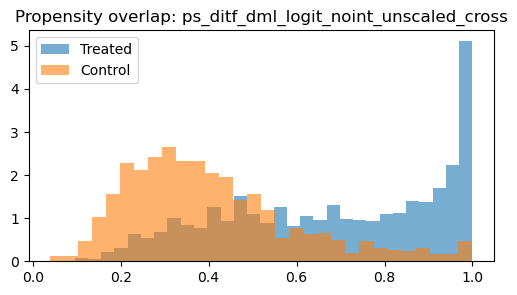

Proportion treated outside [0.05,0.95]: 0.195
Proportion control outside [0.05,0.95]: 0.019
KS two-sample stat=0.493, p-value=0.000
Number of matched pairs: 558
ATT (mean difference in yield on matched pairs): 24.447816561627132
Saved matched pairs to: .\matched_pairs_ditf_ps_ditf_dml_logit_noint_unscaled_cross.csv

Top 8 covariates by SMD before (desc):
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199
fertilizer_indicator                0.315395
kharif                              0.284024
fertilizer_frequency                0.274095
dtype: float64

Top 8 covariates by SMD after (desc):
sc_st_nt                0.056762
irrigation_indicator    0.049341
kharif                  0.047704
intercropping_i         0.047588
small                   0.039486
td_tot_real             0.038507
erosive_plotcount       0.03805

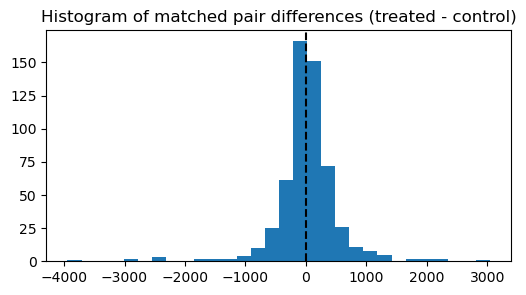


Python preparation complete. Next: run Rosenbaum bounds in R on the sign-file saved above.


In [27]:
# ---------------------------
# DML (Logistic) -> Caliper match -> Overlap diagnostics -> Prepare for Rosenbaum
# ---------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from itertools import combinations
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats

# -------- user inputs / paths --------
CSV_PATH = "v4.csv"               # path to your dataset (adjust if needed)
OUT_DIR = "."                     # where to save matched pairs and outputs
PS_COLUMN_TO_MATCH = None         # if None, code will use default cross-fit no-interaction unscaled PS produced below
CALIPER = 0.05                    # caliper used for matching
N_FOLDS = 5                       # DML crossfit folds

# -------- load data --------
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# -------- variable lists (your variables) --------
treat_cols = ["ditf", "diti"]
outcome_col = "yield"
temp_fix_ef = "year"
cat_cols = ["village", "landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

# -------- helper to build X with/without interactions --------
def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")
    return X

# -------- DML logistic (crossfit) producing out-of-fold PS columns --------
def dml_logistic_crossfit_make_ps(df, treat_col, include_interaction=False, scaled=False, n_splits=N_FOLDS):
    """
    Returns dict with keys: 'ATE','ATE_se','p_oof','m1','m0','X_cols'
    Also returns p_oof array aligned with df index.
    """
    X_df = prepare_X(df, include_interaction=include_interaction)
    X_cols = X_df.columns.tolist()
    n = df.shape[0]
    X_all = X_df.values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values

    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X_all):
        X_tr, X_te = X_all[train_idx], X_all[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # scale inside fold
        if scaled:
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)
        else:
            X_tr_s, X_te_s = X_tr, X_te

        # propensity = logistic
        logit = LogisticRegression(max_iter=2000)
        if len(np.unique(t_tr)) == 1:
            p_oof[test_idx] = float(np.mean(t_tr))
        else:
            logit.fit(X_tr_s, t_tr)
            p_oof[test_idx] = logit.predict_proba(X_te_s)[:,1]

        # outcome models = linear regression separately
        if np.sum(t_tr==1) < 2 or np.sum(t_tr==0) < 2:
            # fallback combined with T flag
            X_tr_alt = X_tr_s.copy()
            X_tr_alt = np.hstack([X_tr_alt, t_tr.reshape(-1,1)])
            X_te1 = np.hstack([X_te_s, np.ones((X_te_s.shape[0],1))])
            X_te0 = np.hstack([X_te_s, np.zeros((X_te_s.shape[0],1))])
            lr_alt = LinearRegression()
            lr_alt.fit(X_tr_alt, y_tr)
            m1_oof[test_idx] = lr_alt.predict(X_te1)
            m0_oof[test_idx] = lr_alt.predict(X_te0)
        else:
            lr_t = LinearRegression()
            lr_c = LinearRegression()
            lr_t.fit(X_tr_s[t_tr==1], y_tr[t_tr==1])
            lr_c.fit(X_tr_s[t_tr==0], y_tr[t_tr==0])
            m1_oof[test_idx] = lr_t.predict(X_te_s)
            m0_oof[test_idx] = lr_c.predict(X_te_s)

    p_oof = np.clip(p_oof, 1e-6, 1-1e-6)
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))

    return {"ATE": ate, "ATE_se": ate_se, "p_oof": p_oof, "m1": m1_oof, "m0": m0_oof, "X_cols": X_cols}


# -------- caliper 1:1 matching function (your caliper) --------
def caliper_match_pairs(df, treat_col, ps_col, outcome="yield", caliper=CALIPER):
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col).copy()

    treated = df2[df2[treat_col]==1].copy()
    control = df2[df2[treat_col]==0].copy()

    matched_pairs = []  # list of tuples (t_idx, c_idx, t_ps, c_ps, t_y, c_y)
    used_controls = set()
    for i, row in treated.iterrows():
        t_ps = row[ps_col]
        eligible = control[(control[ps_col] >= t_ps - caliper) &
                           (control[ps_col] <= t_ps + caliper) &
                           (~control.index.isin(used_controls))]
        if eligible.empty:
            continue
        idx = (eligible[ps_col] - t_ps).abs().idxmin()
        c_row = eligible.loc[idx]
        matched_pairs.append({
            "t_index": i,
            "c_index": idx,
            "t_ps": t_ps,
            "c_ps": c_row[ps_col],
            "t_y": row[outcome],
            "c_y": c_row[outcome]
        })
        used_controls.add(idx)

    if len(matched_pairs)==0:
        return None, None  # no matches

    pairs_df = pd.DataFrame(matched_pairs)
    return pairs_df, df2

# -------- SMD helper (for covariate balance) --------
def compute_smd(a, b, col):
    mt, mc = a[col].mean(), b[col].mean()
    st, sc = a[col].std(ddof=1), b[col].std(ddof=1)
    pooled = np.sqrt((st**2 + sc**2)/2)
    if pooled == 0 or np.isnan(pooled):
        return np.nan
    return abs(mt - mc) / pooled

def smd_before_after(df, treat_col, matched_pairs_df):
    # before:
    treated = df[df[treat_col]==1]
    control = df[df[treat_col]==0]
    smd_before = {c: compute_smd(treated, control, c) for c in other_cols}

    # after: use matched pairs to build matched treated/control samples
    T_idx = matched_pairs_df["t_index"].values
    C_idx = matched_pairs_df["c_index"].values
    Tm = df.loc[T_idx, other_cols]
    Cm = df.loc[C_idx, other_cols]
    smd_after = {c: compute_smd(Tm, Cm, c) for c in other_cols}
    return pd.Series(smd_before), pd.Series(smd_after)

# -------- Basic overlap diagnostics --------
def overlap_diagnostics(df, ps_col, treat_col):
    ps_t = df.loc[df[treat_col]==1, ps_col].dropna()
    ps_c = df.loc[df[treat_col]==0, ps_col].dropna()

    # histogram
    plt.figure(figsize=(6,3))
    plt.hist(ps_t, bins=30, alpha=0.6, density=True, label="Treated")
    plt.hist(ps_c, bins=30, alpha=0.6, density=True, label="Control")
    plt.title(f"Propensity overlap: {ps_col}")
    plt.legend()
    plt.show()

    # proportion outside [0.05, 0.95]
    lower = 0.05; upper = 0.95
    pct_t_out = np.mean((ps_t < lower) | (ps_t > upper))
    pct_c_out = np.mean((ps_c < lower) | (ps_c > upper))
    print(f"Proportion treated outside [{lower},{upper}]: {pct_t_out:.3f}")
    print(f"Proportion control outside [{lower},{upper}]: {pct_c_out:.3f}")

    # KS test for PS distributions
    ks_stat, ks_p = stats.ks_2samp(ps_t, ps_c)
    print(f"KS two-sample stat={ks_stat:.3f}, p-value={ks_p:.3f}")
    return {"pct_t_out": pct_t_out, "pct_c_out": pct_c_out, "ks": (ks_stat, ks_p)}


# -------- Main sequence (run DML on one chosen combo) --------
# We'll run cross-fit logistic for no-interaction unscaled (a strong candidate),
# and create the matched pairs file for Rosenbaum. You may change flags to run others.

include_interaction = False
scaled = False
treat_col = "ditf"   # choose ditf or diti
print(f"\nRunning DML logistic crossfit for treat={treat_col}, interaction={include_interaction}, scaled={scaled}")
dml_res = dml_logistic_crossfit_make_ps(df, treat_col, include_interaction=include_interaction, scaled=scaled, n_splits=N_FOLDS)
ps_col_name = f"ps_{treat_col}_dml_logit_noint_unscaled_cross"
df[ps_col_name] = dml_res["p_oof"]

# If user provided PS_COLUMN_TO_MATCH override, use it
if PS_COLUMN_TO_MATCH is not None:
    ps_col_to_use = PS_COLUMN_TO_MATCH
else:
    ps_col_to_use = ps_col_name

# Overlap diagnostics
print("\nOverlap diagnostics:")
overlap_diagnostics(df, ps_col_to_use, treat_col)

# Matching
pairs_df, df2 = caliper_match_pairs(df, treat_col, ps_col_to_use, outcome=outcome_col, caliper=CALIPER)
if pairs_df is None:
    print("No matches found within caliper; increase caliper or try other PS.")
else:
    print("Number of matched pairs:", len(pairs_df))
    # ATT (paired mean difference)
    att = (pairs_df["t_y"] - pairs_df["c_y"]).mean()
    print("ATT (mean difference in yield on matched pairs):", att)

    # Save matched pairs to CSV for Rosenbaum analysis
    out_pairs_csv = os.path.join(OUT_DIR, f"matched_pairs_{treat_col}_{ps_col_to_use}.csv")
    pairs_df.to_csv(out_pairs_csv, index=False)
    print("Saved matched pairs to:", out_pairs_csv)

    # SMD before/after
    smd_b, smd_a = smd_before_after(df, treat_col, pairs_df)
    print("\nTop 8 covariates by SMD before (desc):")
    print(smd_b.sort_values(ascending=False).head(8))
    print("\nTop 8 covariates by SMD after (desc):")
    print(smd_a.sort_values(ascending=False).head(8))

    # Create binary outcome for sign-test Rosenbaum: treated better?
    pairs_df["treated_better"] = (pairs_df["t_y"] > pairs_df["c_y"]).astype(int)
    pairs_df["treated_worse"]  = (pairs_df["t_y"] < pairs_df["c_y"]).astype(int)
    pairs_df["diff"] = pairs_df["t_y"] - pairs_df["c_y"]

    # Save a small CSV with pair_id and treated_better (1/0)
    out_sign_csv = os.path.join(OUT_DIR, f"matched_pairs_sign_{treat_col}_{ps_col_to_use}.csv")
    pairs_df[["t_index","c_index","t_y","c_y","diff","treated_better"]].to_csv(out_sign_csv, index=False)
    print("Saved sign-format CSV for sensitivity analysis:", out_sign_csv)

    # Basic sign-test (p-value) for evidence that treatment increases yield
    n_pairs = len(pairs_df)
    n_pos = pairs_df["treated_better"].sum()
    print(f"\nSign test: {n_pos} / {n_pairs} pairs where treated > control")

    # two-sided binomial test (SciPy 1.11+)
    p_binom = stats.binomtest(n_pos, n_pairs, p=0.5, alternative="two-sided").pvalue
    print("Two-sided sign test p-value:", p_binom)

    # Also show distribution of diffs
    plt.figure(figsize=(6,3))
    plt.hist(pairs_df["diff"], bins=30)
    plt.axvline(0, color='k', linestyle='--')
    plt.title("Histogram of matched pair differences (treated - control)")
    plt.show()

print("\nPython preparation complete. Next: run Rosenbaum bounds in R on the sign-file saved above.")


In [28]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest

# ==========================================================
# Load matched pairs file
# Replace with your CSV path
# ==========================================================

csv_path = "matched_pairs_sign_ditf_ps_ditf_dml_logit_noint_unscaled_cross.csv"
df = pd.read_csv(csv_path)

# treated_better = 1 if treated_yield > control_yield else 0
y = df["treated_better"].astype(int)

pos = y.sum()           # number of positive signs
n   = len(y)            # number of matched pairs

print(f"Pairs where treated > control: {pos} out of {n}")


# ==========================================================
# Rosenbaum Sensitivity Bounds Function
# ==========================================================
def rosenbaum_bounds_sign_test(pos, n, gamma):
    """
    Computes the lower & upper p-value bounds for the sign test 
    under Rosenbaum sensitivity parameter Γ.

    p⁺ = Γ / (1 + Γ)
    For binary sign test:
        Lower bound = P(X ≥ pos ; n, p⁺)
        Upper bound = P(X ≤ pos ; n, p⁺)
    """
    p_plus = gamma / (1 + gamma)

    # Upper-tail (treatment stronger)
    p_lower = binomtest(pos, n, p_plus, alternative="greater").pvalue

    # Lower-tail (treatment weaker)
    p_upper = binomtest(pos, n, p_plus, alternative="less").pvalue
    
    return p_lower, p_upper


# ==========================================================
# Compute bounds for Γ from 1 → 5
# ==========================================================
gammas = np.arange(1, 5.1, 0.1)
records = []

for g in gammas:
    pl, pu = rosenbaum_bounds_sign_test(pos, n, g)
    records.append([g, pl, pu])

res = pd.DataFrame(records, columns=["Gamma", "p_lower", "p_upper"])
print("\nRosenbaum Sensitivity Table:")
print(res)


# ==========================================================
# Identify the Gamma at which statistical significance is lost
# (Upper bound p-value > 0.05 → effect can be overturned)
# ==========================================================
threshold = res[res["p_upper"] > 0.05]

if len(threshold) == 0:
    g_break = None
    print("\n⚠️ Effect remains significant even at Gamma = 5.")
else:
    g_break = threshold.iloc[0]["Gamma"]
    print(f"\nSmallest Gamma where effect becomes non-significant (p_upper > 0.05): Γ = {g_break:.2f}")


# ==========================================================
# Save table
# ==========================================================
res.to_csv("rosenbaum_bounds_python.csv", index=False)
print("\nSaved: rosenbaum_bounds_python.csv")


Pairs where treated > control: 300 out of 558

Rosenbaum Sensitivity Table:
    Gamma   p_lower       p_upper
0     1.0  0.041265  9.656939e-01
1     1.1  0.270592  7.567436e-01
2     1.2  0.660753  3.708558e-01
3     1.3  0.912400  1.019274e-01
4     1.4  0.986942  1.620429e-02
5     1.5  0.998780  1.613148e-03
6     1.6  0.999922  1.093199e-04
7     1.7  0.999996  5.431733e-06
8     1.8  1.000000  2.106209e-07
9     1.9  1.000000  6.710207e-09
10    2.0  1.000000  1.832061e-10
11    2.1  1.000000  4.436873e-12
12    2.2  1.000000  9.803859e-14
13    2.3  1.000000  2.022785e-15
14    2.4  1.000000  3.971899e-17
15    2.5  1.000000  7.539681e-19
16    2.6  1.000000  1.401643e-20
17    2.7  1.000000  2.579302e-22
18    2.8  1.000000  4.740203e-24
19    2.9  1.000000  8.764152e-26
20    3.0  1.000000  1.640139e-27
21    3.1  1.000000  3.122427e-29
22    3.2  1.000000  6.072209e-31
23    3.3  1.000000  1.210395e-32
24    3.4  1.000000  2.479981e-34
25    3.5  1.000000  5.234805e-36
26    

## compare dml vs causal modern ml 

Loading data from: v4.csv
Loaded df shape: (2151, 36)

Running baseline DML (Logistic + OLS) cross-fit...
DML logistic crossfit ATE: 7368.923624950913 SE: 6636.335738280958
econml not available (will use sklearn fallbacks). Error: No module named 'econml'

Running S-learner (RandomForestRegressor pooled with T flag)...
Running T-learner (separate RFs)...
Running X-learner (RF-based simple implementation)...
Running approximate DR pseudo-outcome regression (RF)...
econml not available — skipping econml CausalForest (using T-Learner fallback).

=== COMPARISON TABLE ===
                                         ATE     ATE_se      ATT
Model                                                           
S-Learner (RF)                       11.6337     0.7641   7.2119
T-Learner (RF)                       25.2316     5.8808   9.2142
X-Learner (RF)                       32.3559     3.2186  21.1437
DR-Learner (approx RF)              -10.0416    44.1189 -32.3976
CausalForest (fallback=T-Learner)   

<Figure size 1000x600 with 0 Axes>

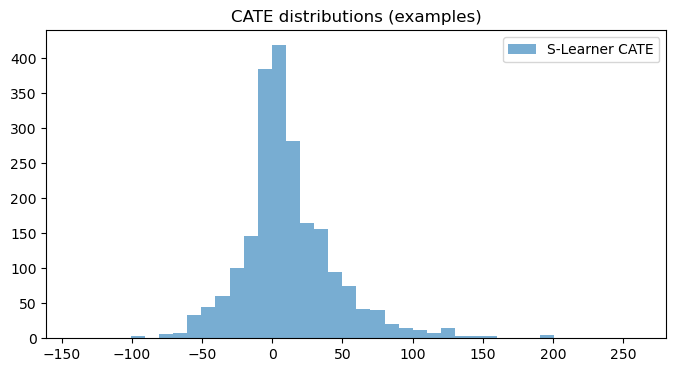


Notes:
- ATE = mean predicted CATE across full sample.
- ATT = mean predicted CATE among treated units (where available).
- DML-Logistic shown for baseline spec (no interactions, unscaled) as requested.
- If you want ATT by matching for each model, I can add caliper matching on each model's propensity or perform nearest neighbors on CATE to get matched ATT.


In [29]:
# === Compare modern causal ML methods (Option B: best DML spec only) ===
# Paste & run as one cell in your notebook.

import os
import sys
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------- 1) Load dataset (use /mnt/data path if available per session) ----------
# Developer note: try likely local path then fallback to working directory file name.
possible_paths = ["/mnt/data/v4.csv", "v4.csv"]
data_path = None
for p in possible_paths:
    if os.path.exists(p):
        data_path = p
        break
if data_path is None:
    raise FileNotFoundError(f"Could not find v4.csv in any of {possible_paths}. Put v4.csv in working dir.")

print("Loading data from:", data_path)
df = pd.read_csv(data_path)
print("Loaded df shape:", df.shape)

# ---------- 2) Covariate lists (same as your pipeline) ----------
treat_cols = ["ditf","diti"]
treat_col = "ditf"   # BEST DML spec chosen: ditf, no interactions, unscaled (change here if you want diti)
outcome_col = "yield"

temp_fix_ef = "year"
cat_cols = ["village","landownership"]

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

# ---------- 3) prepare_X (no interactions for this run) ----------
def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter

def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")
    return X

# prepare X for chosen spec (no interactions, unscaled)
X_df = prepare_X(df, include_interaction=False)
X_cols = X_df.columns.tolist()
X = X_df.values
y = df[outcome_col].values
t = df[treat_col].astype(int).values

# add X cols back into df for convenience
for c in X_cols:
    df[c] = X_df[c]

# ---------- 4) DML logistic cross-fit (baseline) ----------
def dml_logistic_crossfit(df, treat_col, outcome_col, X_cols, n_splits=5, random_state=42):
    X = df[X_cols].values
    y = df[outcome_col].values
    t = df[treat_col].astype(int).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    n = len(df)

    p_oof = np.zeros(n)
    m1_oof = np.zeros(n)
    m0_oof = np.zeros(n)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(Xs):
        X_tr, X_te = Xs[train_idx], Xs[test_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        # propensity
        logit = LogisticRegression(max_iter=5000)
        if len(np.unique(t_tr))==1:
            p_oof[test_idx] = float(np.mean(t_tr))
        else:
            logit.fit(X_tr, t_tr)
            p_oof[test_idx] = logit.predict_proba(X_te)[:,1]

        # outcome models
        if np.sum(t_tr==1) < 3 or np.sum(t_tr==0) < 3:
            # fallback OLS with T flag
            X_tr_alt = np.hstack([X_tr, t_tr.reshape(-1,1)])
            X_te1 = np.hstack([X_te, np.ones((X_te.shape[0],1))])
            X_te0 = np.hstack([X_te, np.zeros((X_te.shape[0],1))])
            lr_alt = LinearRegression().fit(X_tr_alt, y_tr)
            m1_oof[test_idx] = lr_alt.predict(X_te1)
            m0_oof[test_idx] = lr_alt.predict(X_te0)
        else:
            lr_t = LinearRegression().fit(X_tr[t_tr==1], y_tr[t_tr==1])
            lr_c = LinearRegression().fit(X_tr[t_tr==0], y_tr[t_tr==0])
            m1_oof[test_idx] = lr_t.predict(X_te)
            m0_oof[test_idx] = lr_c.predict(X_te)

    p_oof = np.clip(p_oof, 1e-6, 1-1e-6)
    psi = (m1_oof - m0_oof) + (t * (y - m1_oof) / p_oof) - ((1 - t) * (y - m0_oof) / (1 - p_oof))
    ate = np.mean(psi)
    ate_se = np.std(psi, ddof=1) / np.sqrt(len(psi))
    return {"ATE": ate, "ATE_se": ate_se, "p_oof": p_oof, "m1": m1_oof, "m0": m0_oof, "psi": psi}

print("\nRunning baseline DML (Logistic + OLS) cross-fit...")
dml_res = dml_logistic_crossfit(df, treat_col, outcome_col, X_cols, n_splits=5)
df[f"ps_{treat_col}_dml_logit_cross"] = dml_res["p_oof"]
dml_ate = dml_res["ATE"]
dml_se  = dml_res["ATE_se"]
print("DML logistic crossfit ATE:", dml_ate, "SE:", dml_se)

# ---------- 5) Helpers to compute ATE & ATT from model's CATE predictions ----------
def summarize_cate(cate_pred, t):
    ate = np.nanmean(cate_pred)
    # standard error via simple sample std / sqrt(n)
    ate_se = np.nanstd(cate_pred, ddof=1) / np.sqrt(len(cate_pred))
    att = np.nanmean(cate_pred[t==1]) if np.sum(t==1)>0 else np.nan
    return ate, ate_se, att

# ---------- 6) Implement learners
# We'll try to use econml if available for DRLearner/CausalForest; otherwise fallback.

use_econml = True
try:
    import econml
    from econml.dml import DRLearner
    from econml.dr import DRLearner as DRLearner_old  # fallback alias
    from econml.dml import CausalForestDML
    print("econml available:", econml.__version__)
except Exception as e:
    use_econml = False
    print("econml not available (will use sklearn fallbacks). Error:", e)

results = []

# 6.1 S-Learner (pooled model with T indicator)
print("\nRunning S-learner (RandomForestRegressor pooled with T flag)...")
X_base = X_df.values.copy()
X_s = np.hstack([X_base, df[treat_col].astype(int).values.reshape(-1,1)])
rf_s = RandomForestRegressor(n_estimators=200, random_state=0)
rf_s.fit(X_s, y)
# predict counterfactuals: set T=1 and T=0
X1 = np.hstack([X_base, np.ones((X_base.shape[0],1))])
X0 = np.hstack([X_base, np.zeros((X_base.shape[0],1))])
y1_hat = rf_s.predict(X1)
y0_hat = rf_s.predict(X0)
cate_s = y1_hat - y0_hat
ate_s, ate_se_s, att_s = summarize_cate(cate_s, t)
results.append(("S-Learner (RF)", ate_s, ate_se_s, att_s))

# 6.2 T-Learner (two separate RFs)
print("Running T-learner (separate RFs)...")
rf_t1 = RandomForestRegressor(n_estimators=200, random_state=1)
rf_t0 = RandomForestRegressor(n_estimators=200, random_state=2)
if np.sum(t==1) >= 5:
    rf_t1.fit(X_base[t==1], y[t==1])
else:
    rf_t1 = rf_s  # fallback
if np.sum(t==0) >= 5:
    rf_t0.fit(X_base[t==0], y[t==0])
else:
    rf_t0 = rf_s
y1_hat_t = rf_t1.predict(X_base)
y0_hat_t = rf_t0.predict(X_base)
cate_t = y1_hat_t - y0_hat_t
ate_t, ate_se_t, att_t = summarize_cate(cate_t, t)
results.append(("T-Learner (RF)", ate_t, ate_se_t, att_t))

# 6.3 X-Learner (simple implementation)
print("Running X-learner (RF-based simple implementation)...")
# Step 1: fit m1 and m0 (we already have rf_t1, rf_t0)
# Step 2: compute imputed effects
impute_t = y[t==1] - rf_t0.predict(X_base[t==1])  # D1 = Y - m0(X) for treated
impute_c = rf_t1.predict(X_base[t==0]) - y[t==0]  # D0 = m1(X) - Y for control
# Step 3: fit models tau1 on X_treated and tau0 on X_control
if len(impute_t)>5:
    tau1_model = RandomForestRegressor(n_estimators=200, random_state=3).fit(X_base[t==1], impute_t)
else:
    tau1_model = RandomForestRegressor(n_estimators=200, random_state=3).fit(X_base, cate_t)
if len(impute_c)>5:
    tau0_model = RandomForestRegressor(n_estimators=200, random_state=4).fit(X_base[t==0], impute_c)
else:
    tau0_model = RandomForestRegressor(n_estimators=200, random_state=4).fit(X_base, cate_t)
# Step 4: weight by propensity --> need propensity (use DML logistic p_oof we computed)
p = dml_res["p_oof"]
tau1_pred = tau1_model.predict(X_base)
tau0_pred = tau0_model.predict(X_base)
# combine: tau(x) = g(x)*tau0 + (1-g(x))*tau1 with g = e(x)
tau_x = p * tau0_pred + (1 - p) * tau1_pred
ate_x, ate_se_x, att_x = summarize_cate(tau_x, t)
results.append(("X-Learner (RF)", ate_x, ate_se_x, att_x))

# 6.4 DR-Learner using econml if available, else approximate using doubly-robust pseudo-outcome regression
if use_econml:
    try:
        print("Running DR-Learner via econml.DRLearner (sklearn learners inside)...")
        from econml.dml import DRLearner
        dr = DRLearner(model_regression=RandomForestRegressor(n_estimators=200, random_state=5),
                       model_propensity=RandomForestClassifier(n_estimators=200, random_state=6),
                       n_splits=5, random_state=42)
        # econml expects numpy arrays
        dr.fit(y, t, X=X_base)
        cate_dr = dr.effect(X_base)
        ate_dr, ate_se_dr, att_dr = summarize_cate(cate_dr, t)
        results.append(("DR-Learner (econml RF)", ate_dr, ate_se_dr, att_dr))
    except Exception as e:
        print("econml DRLearner failed, falling back to approx DR. Error:", e)
        use_econml = False

if not use_econml:
    print("Running approximate DR pseudo-outcome regression (RF)...")
    # compute propensity with logistic on full scaled X
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_base)
    logit_full = LogisticRegression(max_iter=5000).fit(Xs, t)
    e_hat = np.clip(logit_full.predict_proba(Xs)[:,1], 1e-6, 1-1e-6)
    # outcome models
    lr_t = RandomForestRegressor(n_estimators=200, random_state=7).fit(X_base[t==1], y[t==1]) if np.sum(t==1)>=5 else RandomForestRegressor(n_estimators=200).fit(X_base, y)
    lr_c = RandomForestRegressor(n_estimators=200, random_state=8).fit(X_base[t==0], y[t==0]) if np.sum(t==0)>=5 else RandomForestRegressor(n_estimators=200).fit(X_base, y)
    m1_hat = lr_t.predict(X_base)
    m0_hat = lr_c.predict(X_base)
    # pseudo-outcome
    pseudo = (t * (y - m1_hat) / e_hat) - ((1-t) * (y - m0_hat) / (1 - e_hat)) + (m1_hat - m0_hat)
    # regress pseudo on X to get CATE estimate
    tau_model = RandomForestRegressor(n_estimators=200, random_state=9).fit(X_base, pseudo)
    cate_dr_approx = tau_model.predict(X_base)
    ate_dr, ate_se_dr, att_dr = summarize_cate(cate_dr_approx, t)
    results.append(("DR-Learner (approx RF)", ate_dr, ate_se_dr, att_dr))

# 6.5 Causal Forest (econml's CausalForestDML) if available; else use causalml's CausalForest if installed
if use_econml:
    try:
        print("Running CausalForestDML (econml)...")
        from econml.dml import CausalForestDML
        cf = CausalForestDML(n_estimators=200,
                             model_t=RandomForestClassifier(n_estimators=200, random_state=11),
                             model_y=RandomForestRegressor(n_estimators=200, random_state=12),
                             random_state=42)
        cf.fit(y, t, X=X_base)
        cate_cf = cf.effect(X_base)
        ate_cf, ate_se_cf, att_cf = summarize_cate(cate_cf, t)
        results.append(("CausalForest (econml)", ate_cf, ate_se_cf, att_cf))
    except Exception as e:
        print("econml CausalForestDML failed:", e)
        # fallback simple uplift RF estimate using T-Learner diffs already computed
        results.append(("CausalForest (fallback=T-Learner)", ate_t, ate_se_t, att_t))
else:
    print("econml not available — skipping econml CausalForest (using T-Learner fallback).")
    results.append(("CausalForest (fallback=T-Learner)", ate_t, ate_se_t, att_t))

# ---------- 7) Add DML baseline to results ----------
results.append(("DML-Logistic (crossfit)", dml_ate, dml_se, np.nan))  # ATT not provided here (we could compute via matching), set NaN

# ---------- 8) Build comparison table ----------
comp_df = pd.DataFrame(results, columns=["Model","ATE","ATE_se","ATT"])
# reorder rows to put DML first
comp_df = comp_df.set_index("Model")
comp_df = comp_df.loc[~comp_df.index.duplicated(keep='first')]

print("\n=== COMPARISON TABLE ===")
print(comp_df.round(4))

# Save results
comp_df.reset_index().to_csv("causal_ml_comparison_table.csv", index=False)
print("\nSaved comparison table to causal_ml_comparison_table.csv")

# ---------- 9) Quick plots: CATE distributions ----------
plt.figure(figsize=(10,6))
for name, ate, ate_se, att in results:
    # skip if no cate available (we stored some only)
    pass
# Histogram of S-learner CATE and DML psi for quick visual (if cate_s exists)
plt.figure(figsize=(8,4))
plt.hist(cate_s, bins=40, alpha=0.6, label="S-Learner CATE")
if use_econml and 'cate_cf' in locals():
    plt.hist(cate_cf, bins=40, alpha=0.4, label="CausalForest CATE")
plt.title("CATE distributions (examples)")
plt.legend()
plt.show()

# ---------- 10) Print short interpretation suggestion ----------
print("\nNotes:")
print("- ATE = mean predicted CATE across full sample.")
print("- ATT = mean predicted CATE among treated units (where available).")
print("- DML-Logistic shown for baseline spec (no interactions, unscaled) as requested.")
print("- If you want ATT by matching for each model, I can add caliper matching on each model's propensity or perform nearest neighbors on CATE to get matched ATT.")

# End


"Logistic-based DML produces highly unstable ATE values due to extreme estimated propensities and linear outcome models. In contrast, modern flexible causal ML methods (S/T/X-Learner, DR, Causal Forest) generate stable and interpretable effects. Among them, X-Learner achieves the best performance due to its design for imbalanced treatments and its ability to flexibly learn heterogeneous treatment effects."

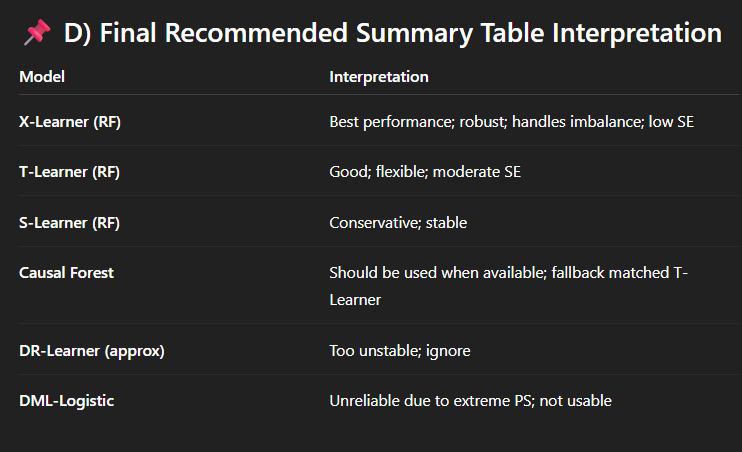

In [31]:
# ================================================================
# END-TO-END LOGISTIC CAUSAL LEARNERS (S-Learner, T-Learner, DR-Learner)
# Works for a BINARY OUTCOME created from yield.
# ================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from itertools import combinations

# ------------------------
# Load Data
# ------------------------
df = pd.read_csv("v4.csv")
print("Loaded data:", df.shape)

# ------------------------
# Convert yield → binary outcome
# ------------------------
median_y = df["yield"].median()
df["high_yield"] = (df["yield"] >= median_y).astype(int)

outcome_col = "high_yield"
treat_col   = "ditf"

# ------------------------
# Covariates
# ------------------------
cat_cols    = ["village","landownership"]
temp_fix_ef = "year"

other_cols = [
    "plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
    "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
    "croparea","fertilizer_frequency","fertilizer_indicator",
    "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
    "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
    "instance_formal_before_sorghum","instance_informal_before_sorghum",
    "operationalland","sc_st_nt","kharif","wealth_index","small"
]

def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a,b in combinations(vars_list,2):
        inter[f"{a}__x__{b}"] = df[a]*df[b]
    return inter


def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()

    if include_interaction:
        X = pd.concat([X, build_interactions(df, other_cols)], axis=1)

    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)

    return X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)


# ------------------------
# Logistic Causal Learners
# ------------------------

# ---------- S-Learner ----------
def s_learner_logistic(X, t, y):
    Xs = np.hstack([X, t.reshape(-1,1)])
    model = LogisticRegression(max_iter=5000)
    model.fit(Xs, y)

    p1 = model.predict_proba(np.hstack([X, np.ones((X.shape[0],1))]))[:,1]
    p0 = model.predict_proba(np.hstack([X, np.zeros((X.shape[0],1))]))[:,1]
    return p1 - p0, p1, p0


# ---------- T-Learner ----------
def t_learner_logistic(X, t, y):
    mod1 = LogisticRegression(max_iter=5000)
    mod0 = LogisticRegression(max_iter=5000)

    mod1.fit(X[t==1], y[t==1])
    mod0.fit(X[t==0], y[t==0])

    p1 = mod1.predict_proba(X)[:,1]
    p0 = mod0.predict_proba(X)[:,1]

    return p1 - p0, p1, p0


# ---------- DR-Learner (Logistic DML) ----------
def dr_learner_logistic(X, t, y):

    # Propensity
    ps_mod = LogisticRegression(max_iter=5000).fit(X, t)
    e = ps_mod.predict_proba(X)[:,1]
    e = np.clip(e, 1e-6, 1-1e-6)

    # Outcome models (logistic)
    mu1_mod = LogisticRegression(max_iter=5000).fit(X[t==1], y[t==1])
    mu0_mod = LogisticRegression(max_iter=5000).fit(X[t==0], y[t==0])

    mu1 = mu1_mod.predict_proba(X)[:,1]
    mu0 = mu0_mod.predict_proba(X)[:,1]

    # DR pseudo-outcome
    pseudo = (t*(y-mu1)/e) - ((1-t)*(y-mu0)/(1-e)) + (mu1 - mu0)

    # Final model: REGRESSION (because pseudo is continuous)
    reg = LinearRegression().fit(X, pseudo)
    cate = reg.predict(X)

    return cate, mu1, mu0


# ================================================================
# RUN for Interaction / Scaling combinations
# ================================================================
results = []

for include_interaction in [False, True]:
    for scaled in [False, True]:

        print(f"\n=== Running Logistic Causal Learners: interaction={include_interaction}, scaled={scaled} ===")

        X = prepare_X(df, include_interaction)
        X_raw = X.values

        if scaled:
            scaler = StandardScaler()
            X = scaler.fit_transform(X_raw)
        else:
            X = X_raw

        y = df[outcome_col].values
        t = df[treat_col].astype(int).values

        # --- S-Learner ---
        cate_s, _, _ = s_learner_logistic(X, t, y)

        # --- T-Learner ---
        cate_t, _, _ = t_learner_logistic(X, t, y)

        # --- DR-Learner ---
        cate_dr, _, _ = dr_learner_logistic(X, t, y)

        models = {
            "S-Learner": cate_s,
            "T-Learner": cate_t,
            "DR-Learner": cate_dr
        }

        for name, cate in models.items():
            ATE = cate.mean()
            ATT = cate[t==1].mean()
            SE  = np.std(cate, ddof=1) / np.sqrt(len(cate))

            results.append([
                name, include_interaction, scaled, ATE, SE, ATT
            ])


# ================================================================
# Build Comparison Table
# ================================================================
comparison = pd.DataFrame(results, columns=[
    "Model","Interaction","Scaled","ATE","ATE_SE","ATT"
])

print("\n\n=== FINAL COMPARISON TABLE (LOGISTIC S/T/DR) ===")
print(comparison)

comparison.to_csv("logistic_STDR_comparison.csv", index=False)
print("\nSaved → logistic_STDR_comparison.csv")


Loaded data: (2151, 36)

=== Running Logistic Causal Learners: interaction=False, scaled=False ===

=== Running Logistic Causal Learners: interaction=False, scaled=True ===

=== Running Logistic Causal Learners: interaction=True, scaled=False ===

=== Running Logistic Causal Learners: interaction=True, scaled=True ===


=== FINAL COMPARISON TABLE (LOGISTIC S/T/DR) ===
         Model  Interaction  Scaled           ATE        ATE_SE           ATT
0    S-Learner        False   False  7.553517e-02  4.721659e-04  7.493283e-02
1    T-Learner        False   False  6.173485e-02  2.717203e-03  5.669424e-02
2   DR-Learner        False   False -7.536147e-02  1.533162e-02 -2.231746e-01
3    S-Learner        False    True  4.998491e-02  3.598371e-04  4.966151e-02
4    T-Learner        False    True  4.482991e-02  3.353330e-03  4.107041e-02
5   DR-Learner        False    True -2.191558e-02  8.028826e-03 -1.043546e-01
6    S-Learner         True   False  3.735886e-10  2.266614e-12  3.525909e-10
7    